# 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import re
from textblob import TextBlob
import os

# Set the file path - using raw string (r) to handle Windows paths
file_path = r'C:\Users\HP 03306897941\Desktop\Junaid\Data Science\Data Science Projects\Loan approval Data\loan_data.csv'

# Verify file exists before loading
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file was not found at: {file_path}")

# Load the data with error handling
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error loading the file: {e}")
    raise

# Initial exploration
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset information:")
print(df.info())

print("\nDescriptive statistics:")
print(df.describe())

# Additional check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Set display options for better viewing of all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Visualize the first few rows with all columns
print("\nFirst 3 rows with all columns:")
print(df.head(3))

Matplotlib is building the font cache; this may take a moment.


Data loaded successfully!

First 5 rows of the dataset:
                                                Text  Income  Credit_Score  \
0  I need a loan to pay for an international vaca...   26556           581   
1  I want to make home improvements like installi...  197392           389   
2  I need a loan for home renovation, including a...   44561           523   
3  I need funds to buy new furniture and applianc...  190363           729   
4           I need a loan to start a small business.   61853           732   

   Loan_Amount  DTI_Ratio Employment_Status  Approval  
0         8314      79.26          employed  Rejected  
1       111604      22.14          employed  Rejected  
2        34118      45.44          employed  Rejected  
3       118757      10.22        unemployed  Rejected  
4        19210      44.13          employed  Approved  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 7 columns):
 #   Colu

Overall Observations:

You have a dataset with 24,000 loan applications.
The statistics provide a central tendency, spread, and range for Income, Credit_Score, Loan_Amount, and DTI_Ratio.
Individual Feature Analysis:

Income:

The average income (mean) is approximately $110,377.
There's a considerable spread in income, as indicated by the standard deviation (std) of around $51,730. This suggests a diverse range of income levels among the applicants.
The income ranges from a minimum of $20,001 to a maximum of $200,000, a fairly wide gap.
The median income (50th percentile) is around $110,464, which is very close to the mean. This suggests a relatively symmetric distribution of income, with no strong skewness.
Credit_Score:

The average credit score is approximately 576.
The standard deviation is about 159, indicating a moderate level of variability in credit scores.
Credit scores range from a low of 300 to a high of 850.
The median credit score is 575, very close to the mean, suggesting a fairly symmetric distribution.
Loan_Amount:

The average loan amount requested is around $44,356.
There's a substantial standard deviation of approximately $34,667, indicating a wide variation in the loan amounts sought.
The loan amounts range from a minimum of $1,005 to a maximum of $158,834.
The median loan amount is $35,207, which is lower than the mean. This suggests a slight positive skew in the loan amount distribution, meaning there are more applications for smaller loan amounts, but some very large loan amounts pull the average higher.
DTI_Ratio (Debt-to-Income Ratio):

The average DTI ratio is about 34.72%.
The standard deviation is relatively high at approximately 32.32, indicating significant variability in the debt burden of the applicants relative to their income.
The DTI ratio ranges from a very low 2.53% to a very high 246.33%. The maximum value looks exceptionally high and might warrant further investigation as a potential outlier or data entry error.
The median DTI ratio is 24.86%, which is notably lower than the mean. This indicates a positive skew in the DTI ratio, meaning most applicants have lower DTI ratios, but some have very high ratios, increasing the average.
Potential Insights and Next Steps:

The wide ranges and standard deviations in Income and Loan_Amount suggest a diverse applicant pool with varying financial needs.
The potentially high maximum DTI_Ratio is a point of concern. It would be beneficial to:
Verify if this value is accurate.
Investigate the characteristics of applications with such high DTI ratios and their approval status.
Consider the impact of such outliers on your model.
The slight positive skew in Loan_Amount and DTI_Ratio distributions might be worth considering during model building and feature scaling.
It would be interesting to see how these numerical features correlate with the Approval status. For instance, do applicants with higher incomes or lower DTI ratios have a higher chance of approval?

 Data Cleaning and Feature Engineering

In [2]:
# Check for missing values
print(df.isnull().sum())

# Convert approval to binary
df['Approval'] = df['Approval'].map({'Approved': 1, 'Rejected': 0})

# Feature engineering from text
def extract_loan_purpose(text):
    # Extract the main purpose from the text
    purposes = ['home renovation', 'business', 'car repair', 'medical', 'education', 
                'vacation', 'debt consolidation', 'wedding', 'furniture', 'investment']
    text = text.lower()
    for purpose in purposes:
        if purpose in text:
            return purpose
    return 'other'

df['Loan_Purpose'] = df['Text'].apply(extract_loan_purpose)

# Sentiment analysis on loan text
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['Sentiment'] = df['Text'].apply(get_sentiment)

# Create DTI categories
df['DTI_Category'] = pd.cut(df['DTI_Ratio'], 
                           bins=[0, 20, 40, 60, 100, 200, np.inf],
                           labels=['0-20', '20-40', '40-60', '60-100', '100-200', '200+'])

# Create income to loan ratio
df['Income_to_Loan_Ratio'] = df['Income'] / df['Loan_Amount']

# Credit score categories
df['Credit_Score_Category'] = pd.cut(df['Credit_Score'],
                                    bins=[0, 579, 669, 739, 799, 850],
                                    labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])

Text                 0
Income               0
Credit_Score         0
Loan_Amount          0
DTI_Ratio            0
Employment_Status    0
Approval             0
dtype: int64


Exploratory Data Analysis

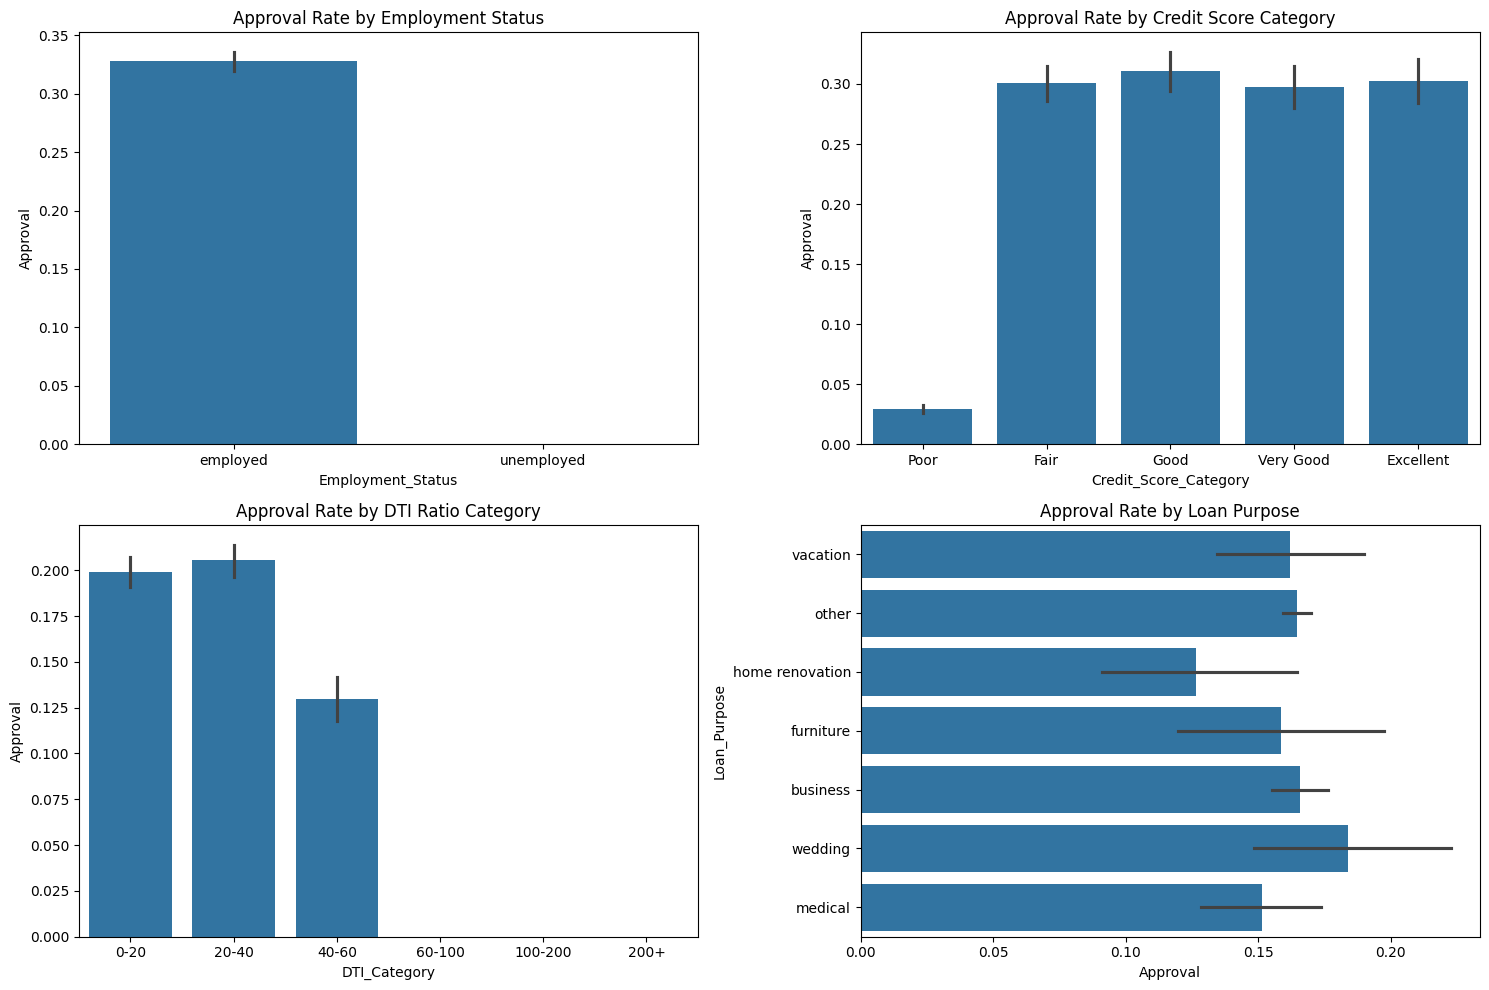

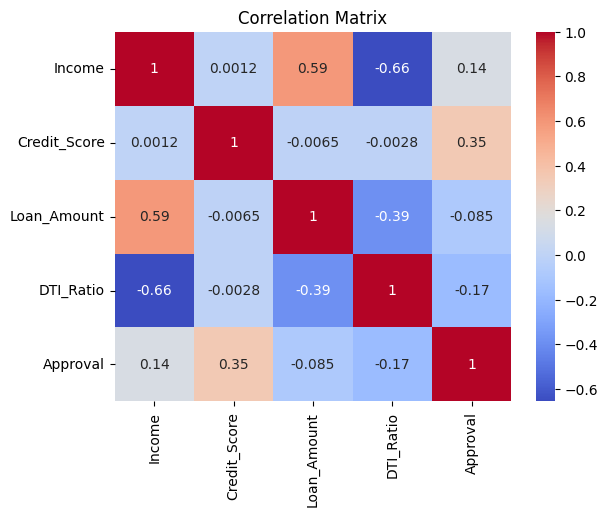

In [3]:
# Approval rate by different features
plt.figure(figsize=(15, 10))

# Approval by employment status
plt.subplot(2, 2, 1)
sns.barplot(x='Employment_Status', y='Approval', data=df)
plt.title('Approval Rate by Employment Status')

# Approval by credit score category
plt.subplot(2, 2, 2)
sns.barplot(x='Credit_Score_Category', y='Approval', data=df, order=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])
plt.title('Approval Rate by Credit Score Category')

# Approval by DTI category
plt.subplot(2, 2, 3)
sns.barplot(x='DTI_Category', y='Approval', data=df)
plt.title('Approval Rate by DTI Ratio Category')

# Approval by loan purpose
plt.subplot(2, 2, 4)
sns.barplot(y='Loan_Purpose', x='Approval', data=df, orient='h')
plt.title('Approval Rate by Loan Purpose')

plt.tight_layout()
plt.show()

# Correlation matrix
corr = df[['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Approval']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Approval Rate by Employment Status
Key Observations:

X-axis: Represents the different categories of employment status: "employed" and "unemployed."
Y-axis: Represents the approval rate, ranging from 0.00 to 0.35 (or 0% to 35%). The height of each bar indicates the proportion of loan applications approved within that employment status category.
Bars: There are two bars, one for "employed" applicants and one for "unemployed" applicants.
Error Bars (Black Lines on Top of Bars): The small black vertical lines on top of each bar represent the confidence interval (likely the standard error) around the estimated approval rate for each group. This gives an idea of the variability or uncertainty in the estimated rate.
Interpretation:

Employed Applicants: The bar for "employed" applicants is significantly higher than the bar for "unemployed" applicants. This indicates that a much larger proportion of employed individuals had their loan applications approved compared to unemployed individuals. The approval rate for employed applicants appears to be around 33% (0.33). The error bar is relatively small, suggesting a more stable estimate of the approval rate for this group.

Unemployed Applicants: The bar for "unemployed" applicants is very low, close to zero. This strongly suggests that very few, if any, unemployed individuals in this dataset had their loan applications approved. The error bar for this group also appears small, indicating a consistent low approval rate.

Conclusion:

This visualization clearly demonstrates a strong relationship between employment status and loan approval. Employed individuals have a substantially higher chance of loan approval compared to unemployed individuals. In this dataset, being employed seems to be a significant factor in the loan approval process. The very low approval rate for unemployed individuals suggests that unemployment is a major barrier to obtaining a loan.

Approval Rate by Credit Score Category
Key Observations:

X-axis: Displays the different credit score categories: "Poor," "Fair," "Good," "Very Good," and "Excellent." These categories are ordered from lower to higher creditworthiness.
Y-axis: Represents the approval rate, ranging from 0.00 to 0.35 (or 0% to 35%). The height of each bar corresponds to the proportion of loan applications approved within each credit score category.
Bars: There are five bars, one for each credit score category.
Error Bars (Black Lines on Top of Bars): The small black vertical lines on top of each bar indicate the confidence interval (likely the standard error) around the estimated approval rate for each category. This provides a measure of the variability or uncertainty in the estimated rate.
Interpretation:

Poor Credit Score: The bar for the "Poor" credit score category is very low, with an approval rate appearing to be around 3%. This suggests that applicants with poor credit scores have a very low chance of loan approval. The error bar is also relatively small.

Fair Credit Score: The approval rate jumps significantly for the "Fair" credit score category, reaching approximately 30%. This indicates a substantial improvement in approval likelihood compared to the "Poor" category. The error bar is slightly larger than for the "Poor" category.

Good Credit Score: The approval rate for the "Good" credit score category is slightly higher than "Fair," hovering around 31%. The error bar is similar in size to the "Fair" category.

Very Good Credit Score: The approval rate for the "Very Good" credit score category is a bit lower than "Good," around 29.5%. The error bar is comparable to the "Fair" and "Good" categories.

Excellent Credit Score: The approval rate for the "Excellent" credit score category rises again to approximately 30%. The error bar is similar in size to the "Fair" and "Good" categories.

Conclusion:

This visualization reveals a clear positive trend between credit score category and loan approval rate, especially when moving from "Poor" to "Fair."

Low Credit Scores = Low Approval: Applicants with "Poor" credit scores face a very low probability of loan approval.
Significant Threshold: There's a substantial increase in approval rate once applicants move into the "Fair" credit score category. This suggests that crossing the "Poor" threshold is critical for loan approval.
Diminishing Returns at Higher Scores: While the approval rate increases from "Poor" to "Fair," the improvement becomes less pronounced as credit scores move from "Fair" to "Good," "Very Good," and "Excellent." The approval rates for these higher categories are relatively similar, suggesting that once a certain creditworthiness level is reached, further increases in the credit score have a smaller impact on the approval rate.

Approval Rate by DTI Ratio Category
Key Observations:

X-axis: Represents the different Debt-to-Income (DTI) ratio categories: "0-20," "20-40," "40-60," "60-100," "100-200," and "200+." These categories represent increasing levels of debt relative to income.
Y-axis: Represents the approval rate, ranging from 0.00 to 0.22 (or 0% to 22%). The height of each bar indicates the proportion of loan applications approved within each DTI ratio category.
Bars: There are six bars, one for each DTI ratio category. Notice that the bars for "60-100," "100-200," and "200+" are either very short or non-existent.
Error Bars (Black Lines on Top of Bars): The small black vertical lines on top of each bar represent the confidence interval (likely the standard error) around the estimated approval rate for each category, indicating the variability in the estimated rate.
Interpretation:

0-20 DTI Ratio: Applicants in the lowest DTI ratio category (0-20%) have a relatively high approval rate, around 20%. The error bar suggests some variability but a generally consistent approval rate for this group.

20-40 DTI Ratio: The approval rate for applicants with a DTI ratio between 20-40% is slightly higher than the 0-20% group, reaching approximately 20.5%. The error bar is also present.

40-60 DTI Ratio: The approval rate drops noticeably for applicants in the 40-60% DTI ratio category, down to around 13%. The error bar is also present, indicating a less favorable approval outlook as DTI increases.

60-100 DTI Ratio: The bar for this category is very short, suggesting a very low approval rate, close to zero.

100-200 DTI Ratio: There appears to be no bar for this category, implying that no applications within this very high DTI range were approved in this dataset.

200+ DTI Ratio: Similarly, there is no bar for the highest DTI category (200+%), indicating zero approvals for applicants with extremely high debt relative to their income.

Conclusion:

This visualization clearly demonstrates a negative relationship between DTI ratio and loan approval rate.

Lower DTI = Higher Approval: Applicants with lower DTI ratios (0-20% and 20-40%) have the highest approval rates. This makes intuitive sense as a lower DTI indicates a greater capacity to manage and repay debt.
Increasing DTI = Decreasing Approval: As the DTI ratio increases, the approval rate tends to decrease. The drop is particularly significant once the DTI ratio exceeds 40%.
Very High DTI = Almost No Approval: Applicants with DTI ratios of 60% and above have a very slim to zero chance of loan approval in this dataset. This strongly suggests that a high DTI ratio is a major risk factor for lenders.
Strong Lending Policy: The complete lack of approvals for DTI ratios above 100% and even very few for 60-100% indicates a strict lending policy regarding the debt burden of applicants.

Approval Rate by Loan Purpose
Key Observations:

Y-axis: Represents the different loan purposes extracted from the text data: "vacation," "other," "home renovation," "furniture," "business," "wedding," and "medical."
X-axis: Represents the approval rate, ranging from 0.00 to 0.22 (or 0% to 22%). The length of each horizontal bar corresponds to the proportion of loan applications approved for that specific purpose.
Bars: There are seven horizontal bars, one for each loan purpose category.
Error Bars (Black Horizontal Lines): The small black horizontal lines extending from each bar represent the confidence interval (likely the standard error) around the estimated approval rate for each loan purpose. This indicates the variability in the estimated rate.
Interpretation:

Vacation: Loan applications for "vacation" purposes have one of the higher approval rates, appearing to be around 16%.

Other: The "other" category also shows a relatively high approval rate, slightly above 16%. This category likely includes loan purposes that didn't fall into the explicitly defined categories.

Home Renovation: Loan applications for "home renovation" have a noticeably lower approval rate compared to "vacation" and "other," around 13%.

Furniture: The approval rate for loans intended for "furniture" is similar to "vacation" and "other," approximately 16%.

Business: Loan applications for "business" purposes show a slightly lower approval rate than some of the top categories, around 15%.

Wedding: Applications for "wedding" loans have the highest approval rate among the listed purposes, appearing to be around 18%.

Medical: Loan applications for "medical" purposes have the lowest approval rate among the specified categories, around 15%.

Conclusion:

This visualization suggests that the stated purpose of the loan application can have some influence on the approval rate, although the differences between most categories aren't extremely large.

Higher Approval Purposes: "Wedding," "vacation," "other," and "furniture" tend to have relatively higher approval rates in this dataset.
Lower Approval Purposes: "Home renovation," "business," and "medical" seem to have somewhat lower approval rates compared to the top categories.
"Other" Category: The relatively high approval rate for the "other" category might warrant further investigation. Understanding what loan purposes fall into this category could provide additional insights.
Error Bar Overlap: Notice that the error bars for several of these categories overlap. This suggests that while there are differences in the point estimates of the approval rates, some of these differences might not be statistically significant.

pairwise linear relationships between the numerical features
Key Observations:

Color Scale: The color scale ranges from deep blue (strong negative correlation, close to -1) to deep red (strong positive correlation, close to +1), with white indicating a near-zero correlation.
Values: Each cell in the matrix contains the Pearson correlation coefficient between the two variables corresponding to that row and column. The value ranges from -1 to +1.
Diagonal: The diagonal cells show a correlation of 1, as each variable is perfectly correlated with itself.
Interpretation of Correlations with Approval:

Income and Approval (0.14): There is a weak positive correlation between income and loan approval. This suggests that, generally, applicants with higher incomes are slightly more likely to be approved for a loan. However, the correlation is not very strong, indicating that income alone is not a primary determinant of approval.

Credit_Score and Approval (0.35): There is a moderate positive correlation between credit score and loan approval. This is a stronger relationship than with income, suggesting that a higher credit score significantly increases the likelihood of loan approval. This aligns with our previous observation from the "Approval Rate by Credit Score Category" plot.

Loan_Amount and Approval (-0.085): There is a very weak negative correlation between loan amount and loan approval. This suggests that applicants requesting larger loan amounts are slightly less likely to be approved. However, the correlation is very close to zero, indicating a minimal linear relationship.

DTI_Ratio and Approval (-0.17): There is a weak negative correlation between DTI ratio and loan approval. This indicates that applicants with a higher debt-to-income ratio are slightly less likely to be approved for a loan. This aligns with our findings from the "Approval Rate by DTI Ratio Category" plot.

Interpretation of Correlations Between Independent Variables:

Income and Loan_Amount (0.59): There is a moderate positive correlation between income and loan amount. This suggests that individuals with higher incomes tend to request larger loan amounts.

Income and DTI_Ratio (-0.66): There is a moderate negative correlation between income and DTI ratio. This is expected, as higher income generally leads to a lower DTI ratio for a given level of debt.

Income and Credit_Score (0.0012): There is a very weak positive correlation (almost zero) between income and credit score, suggesting that these two factors are largely independent in this dataset.

Credit_Score and Loan_Amount (-0.0065): There is a very weak negative correlation (almost zero) between credit score and loan amount, indicating little linear relationship between these two variables.

Credit_Score and DTI_Ratio (-0.0028): There is a very weak negative correlation (almost zero) between credit score and DTI ratio, suggesting minimal linear association.

Loan_Amount and DTI_Ratio (-0.39): There is a weak negative correlation between loan amount and DTI ratio. This might suggest that individuals requesting larger loans tend to have a slightly lower DTI ratio, possibly because their higher requested debt is still manageable relative to their income (which we saw is positively correlated with loan amount).

Overall Conclusions:

Credit Score is a Key Predictor: Among the numerical features, credit score shows the strongest linear correlation with loan approval.
DTI Ratio Matters (Negatively): A higher debt burden relative to income tends to decrease the likelihood of approval.
Income Has a Modest Positive Influence: Higher income is generally favorable for loan approval, but its linear relationship is not as strong as credit score.
Loan Amount Has a Minimal Linear Impact: The requested loan amount has a very weak negative linear association with approval.
Inter-Feature Relationships: There are some notable correlations between the independent variables, particularly between income and loan amount, and income and DTI ratio. These relationships might be important to consider during model building to avoid multicollinearity issues if using linear models.

Machine Learning Model

In [4]:
# Prepare data for modeling
X = df[['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Sentiment']]
X = pd.get_dummies(X)  # In case we add categorical variables
y = df['Approval']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

# Hyperparameter tuning (optional)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Accuracy: 0.8369444444444445

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6068
           1       0.48      0.42      0.45      1132

    accuracy                           0.84      7200
   macro avg       0.69      0.67      0.68      7200
weighted avg       0.83      0.84      0.83      7200


Confusion Matrix:
[[5553  515]
 [ 659  473]]
              importance
Credit_Score    0.330012
Loan_Amount     0.228546
DTI_Ratio       0.205321
Income          0.193398
Sentiment       0.042723


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

Basic Overview Visualizations

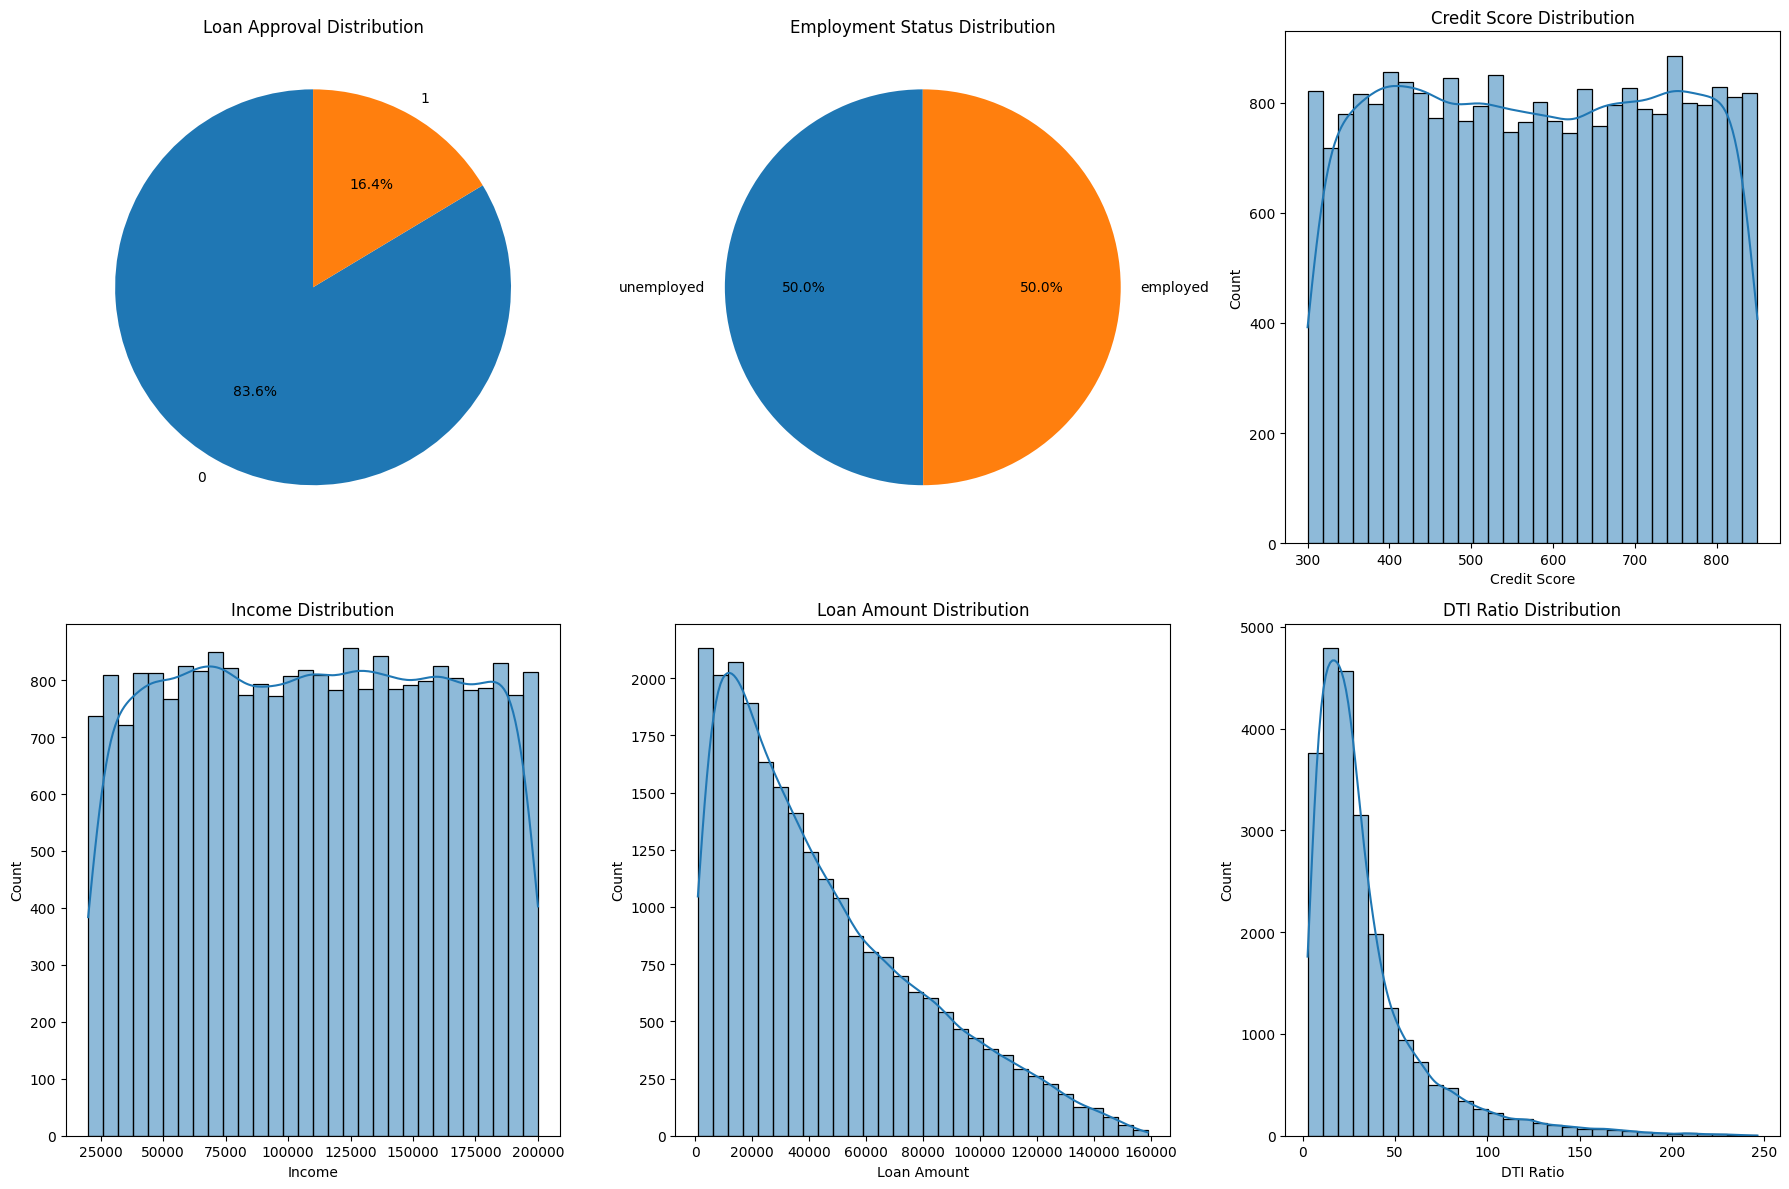

In [5]:
# Create a figure with multiple subplots
plt.figure(figsize=(18, 12))

# 1. Approval Distribution
plt.subplot(2, 3, 1)
approval_counts = df['Approval'].value_counts()
plt.pie(approval_counts, labels=approval_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Loan Approval Distribution')

# 2. Employment Status Distribution
plt.subplot(2, 3, 2)
employment_counts = df['Employment_Status'].value_counts()
plt.pie(employment_counts, labels=employment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Employment Status Distribution')

# 3. Credit Score Distribution
plt.subplot(2, 3, 3)
sns.histplot(df['Credit_Score'], bins=30, kde=True)
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')

# 4. Income Distribution
plt.subplot(2, 3, 4)
sns.histplot(df['Income'], bins=30, kde=True)
plt.title('Income Distribution')
plt.xlabel('Income')

# 5. Loan Amount Distribution
plt.subplot(2, 3, 5)
sns.histplot(df['Loan_Amount'], bins=30, kde=True)
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')

# 6. DTI Ratio Distribution
plt.subplot(2, 3, 6)
sns.histplot(df['DTI_Ratio'], bins=30, kde=True)
plt.title('DTI Ratio Distribution')
plt.xlabel('DTI Ratio')

plt.tight_layout()
plt.show()

Loan Approval Distribution
Key Observations:

Title: The title clearly indicates that this chart shows how loan applications are distributed in terms of their approval status.
Slices: The pie chart is divided into two slices, each representing one of the two categories of the 'Approval' variable. Based on your earlier code, '0' likely represents "Rejected" and '1' likely represents "Approved."
Percentages: Each slice is labeled with a percentage value indicating the proportion of the total data that falls into that approval category.
The larger blue slice, labeled '0', represents 83.6%.
The smaller orange slice, labeled '1', represents 16.4%.
Interpretation:

This pie chart provides a clear view of the class distribution for loan approval in your dataset:

Majority Rejected: A significantly larger portion of the loan applications were rejected. Approximately 83.6% of the applications resulted in a 'Rejected' outcome.
Minority Approved: Only a small fraction of the loan applications were approved. Approximately 16.4% of the applications received an 'Approved' status.
Conclusion:

The loan approval distribution in this dataset is heavily skewed towards rejection. For every approximately 100 loan applications, about 84 were rejected, and only about 16 were approved. This indicates an imbalanced dataset with respect to the target variable.

Employment Status Distribution
Key Observations:

Title: The title clearly indicates that this chart shows how the loan applicants in your dataset are distributed based on their employment status.
Slices: The pie chart is divided into two equal-sized slices.
Labels: Each slice is labeled with an employment status category: "unemployed" and "employed."
Percentages: Each slice is also labeled with a percentage value: 50.0% for "unemployed" and 50.0% for "employed."
Interpretation:

This pie chart reveals a perfectly balanced distribution of employment status among the loan applicants in your dataset:

Equal Representation: Exactly half (50.0%) of the applicants are categorized as "unemployed."
Equal Representation: The other half (50.0%) of the applicants are categorized as "employed."
Conclusion:

The dataset has an equal number of employed and unemployed individuals who applied for loans. This balanced representation is interesting, especially considering the significant difference in approval rates between these two groups that we observed in the "Approval Rate by Employment Status" bar plot.

Credit Score Distribution

Key Observations:

Title: The title clearly indicates that this plot displays how the credit scores of the loan applicants are distributed.
X-axis: Represents the credit score values, ranging from approximately 300 to 850. This is the typical range for FICO scores, a common credit scoring model.
Y-axis: Represents the count (or frequency) of applicants within each credit score bin. The height of each bar indicates how many applicants have a credit score within that specific range.
Bars (Bins): The histogram is composed of multiple bars, each representing a range of credit scores. The width of each bar is the same, and the height varies according to the number of applicants in that range.
KDE Line (Blue Curve): A blue curve is overlaid on the histogram. This is a Kernel Density Estimate (KDE), which provides a smoothed representation of the underlying distribution of the credit scores. It helps to visualize the overall shape of the distribution without the jaggedness of the histogram bars.
Interpretation of the Distribution:

Relatively Uniform Distribution: The histogram and the KDE line suggest that the credit scores in this dataset are somewhat uniformly distributed across the range, particularly between approximately 350 and 850. There isn't a single, dominant peak indicating a large concentration of applicants at one specific credit score.
Slight Peaks and Valleys: While generally uniform, there are some minor peaks and valleys in the distribution. For instance, there appear to be slight increases in the number of applicants around the lower 400s and the mid-700s. Conversely, there might be slight dips in the frequency around the lower 300s and the upper 600s. However, these variations are not very pronounced.
Presence Across the Entire Range: There are applicants with credit scores spanning nearly the entire typical FICO range (300-850), although the frequency appears lower at the extreme ends.
Conclusion:

The credit scores of the loan applicants in this dataset are broadly distributed across the typical credit score range, without a strong central tendency. This suggests a diverse applicant pool in terms of creditworthiness.

Income Distribution
Key Observations:

Title: The title clearly indicates that this plot displays how the incomes of the loan applicants are distributed.
X-axis: Represents the income values, ranging from approximately $20,000 to $200,000.
Y-axis: Represents the count (or frequency) of applicants within each income bin. The height of each bar indicates how many applicants have an income within that specific range.
Bars (Bins): The histogram is composed of multiple bars, each representing a range of income. The width of each bar is the same, and the height varies according to the number of applicants in that range.
KDE Line (Blue Curve): A blue curve is overlaid on the histogram. This is a Kernel Density Estimate (KDE), which provides a smoothed representation of the underlying distribution of the incomes. It helps to visualize the overall shape of the distribution without the jaggedness of the histogram bars.
Interpretation of the Distribution:

Relatively Uniform Distribution: Similar to the credit score distribution, the histogram and the KDE line suggest that the income in this dataset is also somewhat uniformly distributed across the observed range ($20,000 to $200,000). There isn't a strong central peak indicating a concentration of applicants at a particular income level.
Minor Fluctuations: There are some minor ups and downs in the frequency across the income range. For example, there might be slightly higher frequencies around the $50,000, $100,000, and $150,000 marks, and slight dips in between. However, these variations are not very substantial, and the overall distribution appears relatively flat.
Presence Across the Entire Range: Applicants in this dataset have incomes spanning the entire range from the minimum to the maximum reported values, with a fairly consistent number of applicants in each income bracket.
Conclusion:

The income distribution of the loan applicants in this dataset is relatively uniform across the range of $20,000 to $200,000. This indicates a diverse set of applicants with varying income levels, without a strong concentration in any particular income bracket.

Loan Amount Distribution
Key Observations:

Title: The title clearly indicates that this plot displays how the requested loan amounts of the applicants are distributed.
X-axis: Represents the loan amount values, ranging from approximately $0 to $160,000.
Y-axis: Represents the count (or frequency) of applicants requesting a loan amount within each bin. The height of each bar indicates how many applicants applied for a loan within that specific range.
Bars (Bins): The histogram is composed of multiple bars, each representing a range of loan amounts. The width of each bar is the same, and the height varies according to the number of applicants in that range.
KDE Line (Blue Curve): A blue curve is overlaid on the histogram. This is a Kernel Density Estimate (KDE), providing a smoothed representation of the underlying distribution of the loan amounts.
Interpretation of the Distribution:

Positive Skew: The most striking feature of this distribution is its strong positive skew. The majority of loan applications are for smaller amounts, with the frequency of applications decreasing as the requested loan amount increases. The peak of the distribution is clearly towards the lower end of the loan amount range.
High Frequency of Smaller Loans: There is a very high count of applicants requesting loan amounts in the lower range, roughly below $20,000.
Long Tail: The distribution has a long tail extending towards the higher loan amounts, indicating that while less frequent, there are still a significant number of applications for larger sums, up to the maximum observed value.
Decreasing Trend: The KDE line clearly shows a downward trend as the loan amount increases, confirming that larger loan requests are progressively less common in this dataset.
Conclusion:

The distribution of loan amounts requested by applicants in this dataset is heavily skewed to the right. Most applicants seek smaller loans, and the number of applications decreases substantially as the requested loan amount grows.


DTI Ratio Distribution
Key Observations:

Title: The title clearly indicates that this plot displays how the Debt-to-Income (DTI) ratios of the loan applicants are distributed.
X-axis: Represents the DTI ratio values, ranging from approximately 0 to 250.
Y-axis: Represents the count (or frequency) of applicants with a DTI ratio within each bin. The height of each bar indicates how many applicants fall into that specific DTI ratio range.
Bars (Bins): The histogram is composed of multiple bars, each representing a range of DTI ratios.
KDE Line (Blue Curve): A blue curve is overlaid, providing a smoothed representation of the underlying DTI ratio distribution.
Interpretation of the Distribution:

Strong Positive Skew: This distribution exhibits a strong positive skew, similar to the loan amount distribution but perhaps even more pronounced. The vast majority of applicants have relatively low DTI ratios, with the frequency dropping sharply as the DTI ratio increases.
Peak at Low DTI: The distribution peaks at a very low DTI ratio, likely below 20. This indicates that a large number of applicants have a small amount of debt relative to their income.
Long and Thin Tail: The distribution has a very long and thin tail extending towards higher DTI ratios. While the number of applicants with high DTI ratios is small, they do exist in the dataset, extending to very high values (as we noted in the descriptive statistics).
Rapid Decline: The KDE line shows a rapid decline in the density of applicants as the DTI ratio increases from the peak.
Conclusion:

The Debt-to-Income ratios of the loan applicants in this dataset are overwhelmingly concentrated at the lower end of the spectrum. Most applicants have a relatively low debt burden compared to their income, and the number of applicants decreases dramatically as the DTI ratio rises.

Approval Rate Analysis by Different Factors

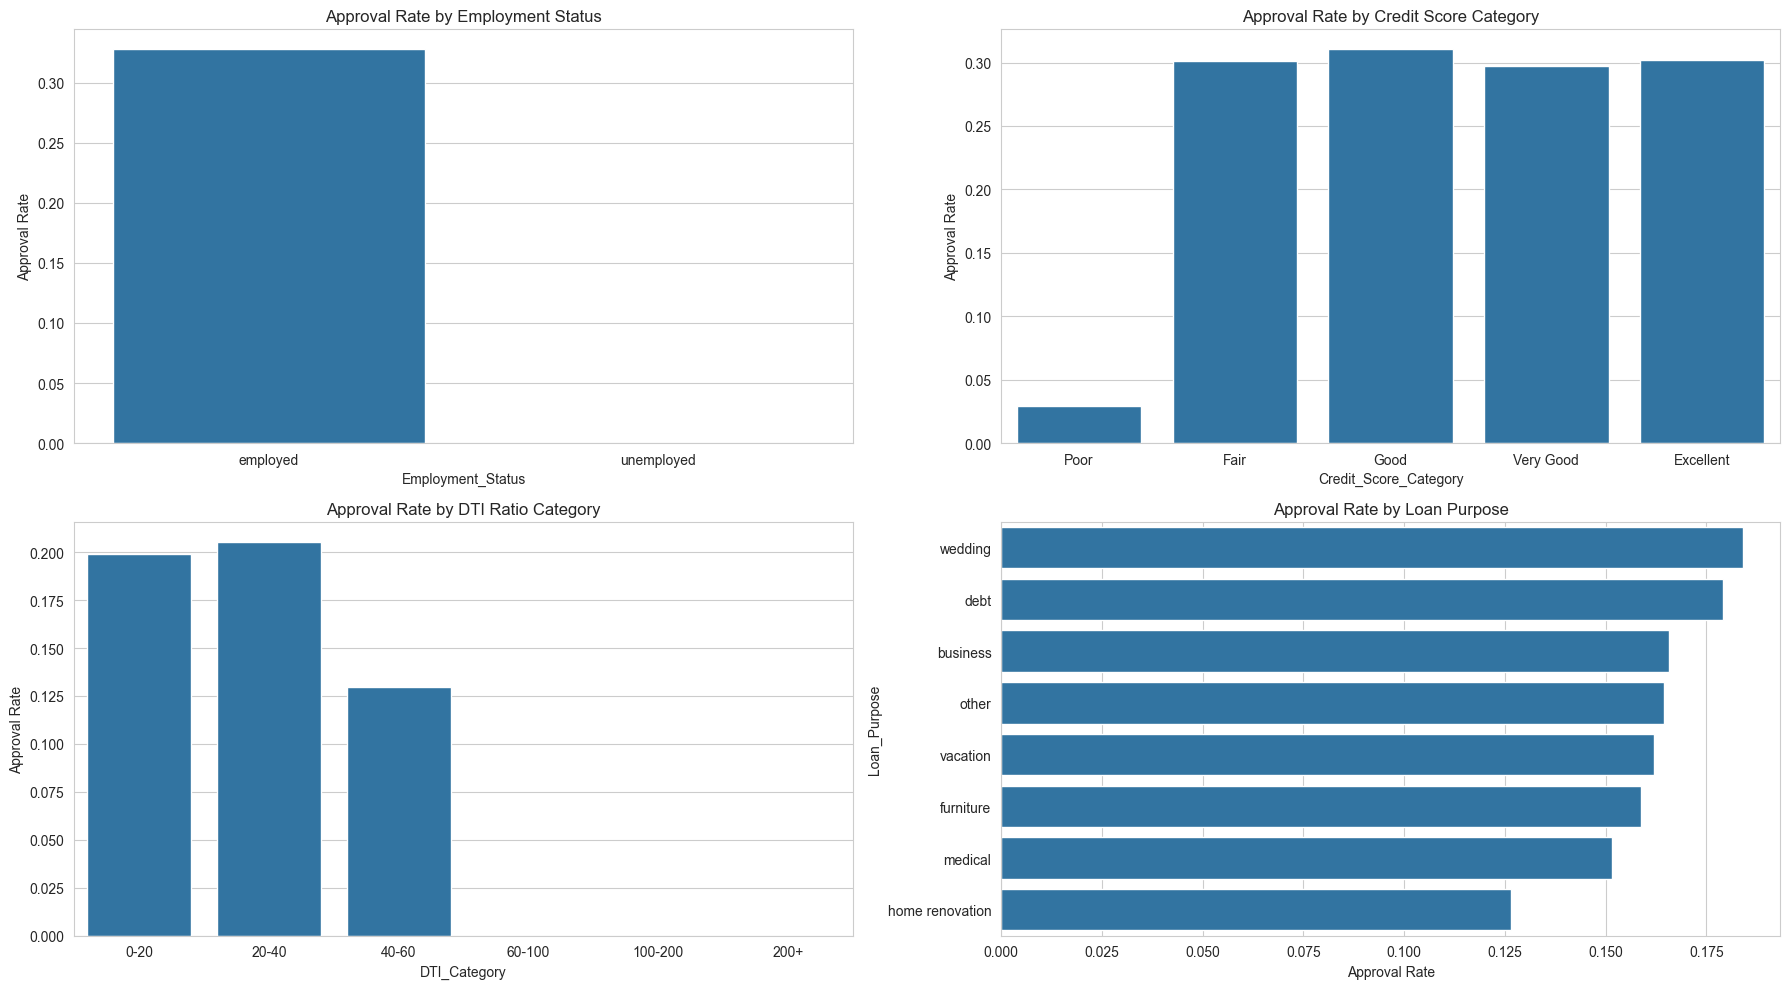

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# Load the data (adjust path as needed)
file_path = r'C:\Users\HP 03306897941\Desktop\Junaid\Data Science\Data Science Projects\Loan approval Data\loan_data.csv'
df = pd.read_csv(file_path)

# Convert Approval to binary (1 for Approved, 0 for Rejected)
df['Approval_Binary'] = df['Approval'].map({'Approved': 1, 'Rejected': 0})

# Create a figure for approval rate analysis
plt.figure(figsize=(18, 10))

# 1. Approval Rate by Employment Status
plt.subplot(2, 2, 1)
sns.barplot(x='Employment_Status', y='Approval_Binary', data=df, errorbar=None)
plt.title('Approval Rate by Employment Status')
plt.ylabel('Approval Rate')

# 2. Approval Rate by Credit Score Category
df['Credit_Score_Category'] = pd.cut(df['Credit_Score'],
                                    bins=[0, 579, 669, 739, 799, 850],
                                    labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])

plt.subplot(2, 2, 2)
sns.barplot(x='Credit_Score_Category', y='Approval_Binary', data=df, 
            order=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'], errorbar=None)
plt.title('Approval Rate by Credit Score Category')
plt.ylabel('Approval Rate')

# 3. Approval Rate by DTI Ratio Category
df['DTI_Category'] = pd.cut(df['DTI_Ratio'], 
                           bins=[0, 20, 40, 60, 100, 200, np.inf],
                           labels=['0-20', '20-40', '40-60', '60-100', '100-200', '200+'])

plt.subplot(2, 2, 3)
sns.barplot(x='DTI_Category', y='Approval_Binary', data=df, errorbar=None)
plt.title('Approval Rate by DTI Ratio Category')
plt.ylabel('Approval Rate')

# 4. Approval Rate by Loan Purpose (extracted from text)
def extract_loan_purpose(text):
    purposes = ['home renovation', 'business', 'car repair', 'medical', 'education', 
                'vacation', 'debt', 'wedding', 'furniture', 'investment']
    text = text.lower()
    for purpose in purposes:
        if purpose in text:
            return purpose
    return 'other'

df['Loan_Purpose'] = df['Text'].apply(extract_loan_purpose)

plt.subplot(2, 2, 4)
purpose_order = df.groupby('Loan_Purpose')['Approval_Binary'].mean().sort_values(ascending=False).index
sns.barplot(y='Loan_Purpose', x='Approval_Binary', data=df, order=purpose_order, errorbar=None)
plt.title('Approval Rate by Loan Purpose')
plt.xlabel('Approval Rate')

plt.tight_layout()
plt.show()

Approval Rate by Employment Status
Key Observations:

X-axis: Represents the two categories of employment status: "employed" and "unemployed."
Y-axis: Represents the approval rate, ranging from 0.00 to 0.35 (or 0% to 35%). The height of each bar indicates the proportion of loan applications approved within that employment status category.
Bars: There are two bars:
A taller bar for "employed" applicants.
A much shorter bar for "unemployed" applicants, which appears to be very close to zero.
Interpretation:

This plot clearly shows a significant difference in loan approval rates based on employment status:

Employed Applicants: The "employed" group has a noticeably higher approval rate. The bar suggests an approval rate of approximately 0.33 or 33%.
Unemployed Applicants: The "unemployed" group has a very low approval rate, close to 0%. This indicates that almost none of the unemployed applicants in this dataset were approved for a loan.
Conclusion:

Employment status is a strong indicator of loan approval in this dataset. Being employed significantly increases the likelihood of loan approval, while being unemployed makes it highly improbable.

Approval Rate by Credit Score Category
Key Observations:

X-axis: Displays the different credit score categories: "Poor," "Fair," "Good," "Very Good," and "Excellent," ordered from lower to higher creditworthiness.
Y-axis: Represents the approval rate, ranging from 0.00 to 0.30 (or 0% to 30%). The height of each bar corresponds to the proportion of loan applications approved within each credit score category.
Bars: There are five bars, one for each credit score category.
Interpretation:

This plot reveals a clear trend between credit score category and loan approval rate:

Poor Credit Score: The bar for the "Poor" credit score category is very low, indicating a low approval rate, approximately 0.03 or 3%.
Fair Credit Score: The approval rate jumps significantly for the "Fair" credit score category, reaching approximately 0.30 or 30%.
Good Credit Score: The approval rate for the "Good" credit score category is slightly higher than "Fair," around 0.31 or 31%.
Very Good Credit Score: The approval rate for the "Very Good" credit score category is a bit lower than "Good," around 0.30 or 30%.
Excellent Credit Score: The approval rate for the "Excellent" credit score category is similar to "Fair" and "Very Good," around 0.30 or 30%.
Conclusion:

There is a strong positive correlation between credit score and loan approval, particularly when moving from the "Poor" category to the higher categories.

Low Credit Score = Low Approval: Applicants with "Poor" credit scores have a very low chance of loan approval.
Significant Improvement: Moving to a "Fair" credit score results in a substantial increase in the approval rate.
Diminishing Returns at Higher Scores: While approval rates are high for "Fair," "Good," "Very Good," and "Excellent" categories, the difference in approval rates among these higher categories is relatively small. This suggests that once an applicant reaches a "Fair" credit score, further improvements in the credit score have a less dramatic impact on the approval rate in this dataset.

Approval Rate by DTI Ratio Category

This bar chart illustrates the relationship between different Debt-to-Income (DTI) ratio categories and the corresponding loan approval rates. The x-axis shows the DTI categories ("0-20", "20-40", "40-60", "60-100", "100-200", "200+"), representing increasing levels of debt relative to income. The y-axis displays the approval rate, ranging from 0.00 to 0.22 (or 0% to 22%). The height of each bar indicates the proportion of loan applications approved within that specific DTI category. The black vertical lines on top of the bars represent the error bars, indicating the confidence interval around the estimated approval rate.

Key Observations and Interpretation:

Lowest DTI (0-20%): This category has a relatively high approval rate, around 20%. The error bar suggests a moderate level of precision in this estimate.
Low DTI (20-40%): The approval rate is slightly higher than the 0-20% range, at approximately 20.5%. The error bar is similar in size.
Moderate DTI (40-60%): There's a noticeable drop in the approval rate to about 13%. The error bar is also present, indicating a less favorable approval outlook as DTI increases.
High DTI (60-100%): The bar is very short, indicating a very low approval rate, close to zero.
Very High DTI (100-200% and 200+): There are no visible bars for these categories, suggesting a zero or near-zero approval rate for applicants with extremely high debt relative to their income.
Conclusion:

The plot clearly demonstrates a negative correlation between DTI ratio and loan approval rate. Applicants with lower DTI ratios (indicating a healthier balance between debt and income) have significantly higher chances of loan approval. As the DTI ratio increases, the approval rate declines sharply. Notably, applicants with DTI ratios exceeding 60% have a minimal to nonexistent chance of approval in this dataset, highlighting a strict lending policy regarding debt burden.

Approval Rate by Loan Purpose
Key Observations:

Y-axis: Represents the different loan purposes: "wedding," "debt," "business," "other," "vacation," "furniture," "medical," and "home renovation."
X-axis: Represents the approval rate, ranging from 0.00 to 0.18 (or 0% to 18%). The length of each horizontal bar corresponds to the proportion of loan applications approved for that specific purpose.
Bars: There are eight horizontal bars, one for each loan purpose category.
Interpretation:

This visualization shows the approval rates for different stated loan purposes:

Wedding: Loan applications for "wedding" purposes have the highest approval rate, approximately 0.18 or 18%.
Debt: Loan applications for "debt" (likely debt consolidation) have the second-highest approval rate, around 0.17 or 17%.
Business: Loan applications for "business" purposes have an approval rate of around 0.16 or 16%.
Other: The "other" category has an approval rate slightly above 0.16 or 16%. This category likely includes loan purposes that didn't fall into the explicitly defined categories.
Vacation: Loan applications for "vacation" purposes have an approval rate of approximately 0.16 or 16%.
Furniture: Loan applications for "furniture" have an approval rate of around 0.16 or 16%.
Medical: Loan applications for "medical" purposes have an approval rate of approximately 0.15 or 15%.
Home Renovation: Loan applications for "home renovation" have the lowest approval rate among the listed purposes, around 0.13 or 13%.
Conclusion:

The stated purpose of the loan application appears to have some influence on the approval rate, although the range of approval rates across different purposes isn't extremely wide (from about 13% to 18%).

Higher Approval Purposes: "Wedding" and "debt" consolidation tend to have slightly higher approval rates. "Business," "other," "vacation," and "furniture" have similar, moderately higher approval rates.
Lower Approval Purposes: "Medical" and, notably, "home renovation" have the lower approval rates among the listed categories.

Setup & Initial Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# Set style for all visualizations
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
%matplotlib inline

Target Variable Distribution

C:\Users\HP 03306897941\AppData\Local\Temp\ipykernel_13568\2632073848.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Approval', data=df, palette='Set2')


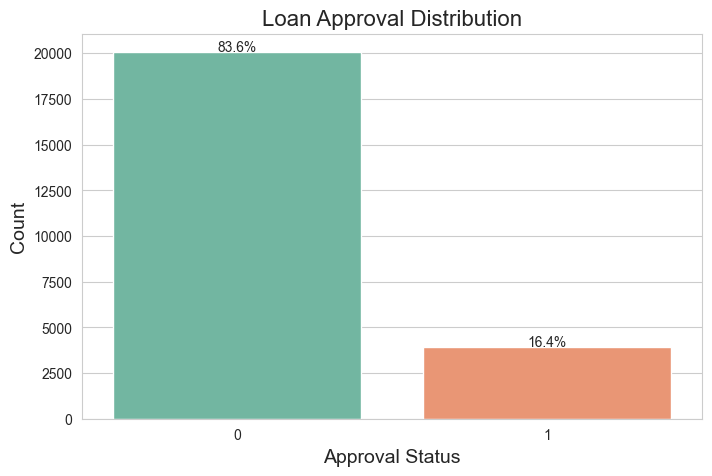

In [9]:
# Approval status countplot
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Approval', data=df, palette='Set2')
plt.title('Loan Approval Distribution', fontsize=16)
plt.xlabel('Approval Status', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add percentage annotations
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 20
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

Loan Approval Distribution
Key Observations:

Title: The title clearly indicates that this plot shows how loan applications are distributed based on their approval status.
X-axis: Represents the approval status, with '0' and '1' likely representing "Rejected" and "Approved" respectively (consistent with your earlier code where you mapped 'Rejected' to 0 and 'Approved' to 1).
Y-axis: Represents the count (or frequency) of loan applications for each approval status.
Bars: There are two bars:
A tall, teal bar for approval status '0'.
A shorter, coral bar for approval status '1'.
Percentage Labels: Each bar has a percentage label above it, indicating the proportion of the total data that falls into that approval category.
The bar for '0' (Rejected) is labeled with 83.6%.
The bar for '1' (Approved) is labeled with 16.4%.
Interpretation:

This bar plot visually confirms the imbalanced distribution of the loan approval outcome in your dataset:

Majority Rejected: The vast majority of loan applications were rejected. Approximately 83.6% of the applications resulted in a 'Rejected' status.
Minority Approved: Only a small fraction of the loan applications were approved. Approximately 16.4% of the applications received an 'Approved' status.
Conclusion:

The loan approval distribution in this dataset is significantly skewed towards rejection. For every approximately 100 loan applications, about 84 were rejected, and only about 16 were approved. This reinforces the observation of class imbalance that we noted earlier from the pie chart showing the same data.

Numerical Features Analysis

 Distribution Plots

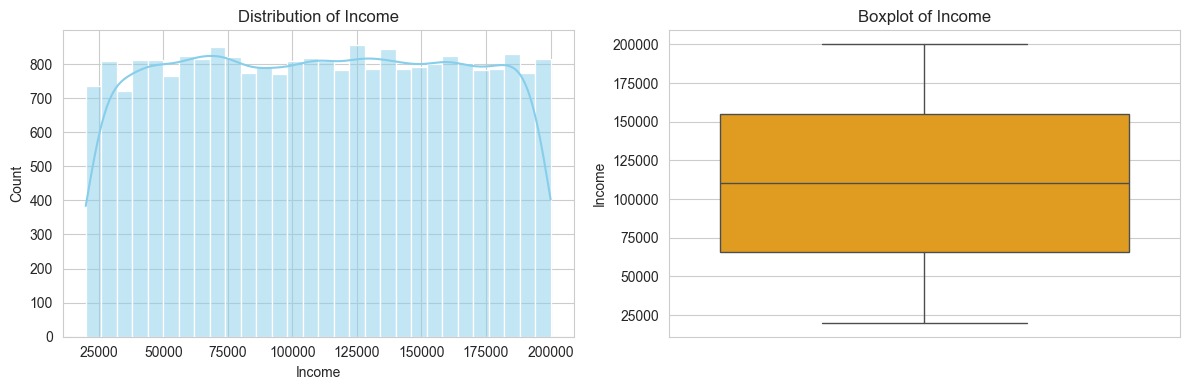

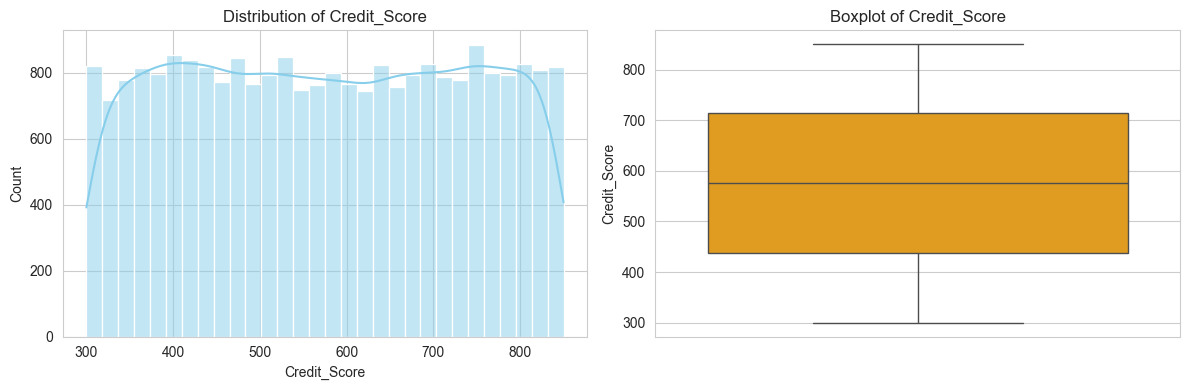

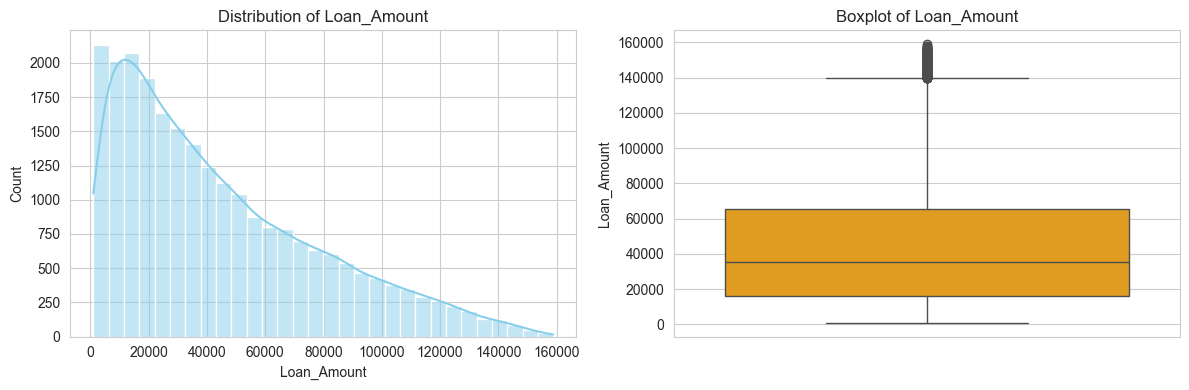

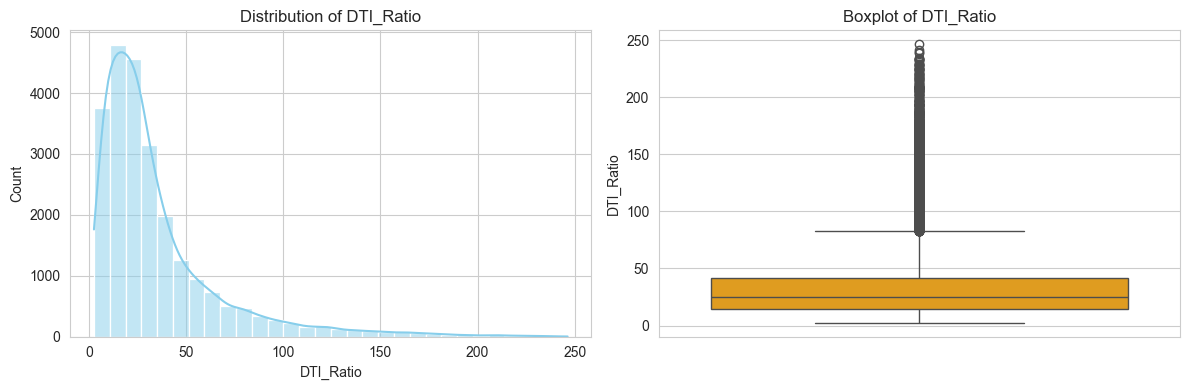

In [10]:
num_cols = ['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio']

for col in num_cols:
    plt.figure(figsize=(12, 4))
    
    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {col}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[col], color='orange')
    plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()

Distribution of Income
Key Observations:

Title: The title clearly indicates that this plot displays how the incomes of the loan applicants are distributed.
X-axis: Represents the income values, ranging from approximately $20,000 to $200,000.
Y-axis: Represents the count (or frequency) of applicants within each income bin. The height of each bar indicates how many applicants have an income within that specific range.
Bars (Bins): The histogram is composed of multiple bars, each representing a range of income. The width of each bar is consistent.
KDE Line (Light Blue Curve): A light blue curve is overlaid on the histogram. This is a Kernel Density Estimate (KDE), which provides a smoothed representation of the underlying distribution of the incomes.
Interpretation of the Distribution:

Relatively Uniform Distribution: The most prominent feature of this distribution is its relatively uniform spread across the entire income range. Unlike distributions that might peak at a certain income level, this one shows a fairly consistent number of applicants in each income bracket from the minimum to the maximum.
Minor Fluctuations: While generally uniform, there are some slight undulations in the histogram bars and the KDE line. There might be slightly higher frequencies around certain income levels and slightly lower frequencies in others, but these variations are not very pronounced.
Presence Across the Entire Range: The fact that there are bars across the entire income spectrum indicates that your dataset includes loan applicants with a wide variety of income levels, from the lower end ($20,000) to the higher end ($200,000).
Conclusion:

The income distribution of the loan applicants in this dataset is relatively even across the observed range. This suggests a diverse applicant pool in terms of income, without a strong concentration in any particular income segment.

boxplot of "Income
Key Observations:

Title: The title clearly indicates that this plot visualizes the distribution of the 'Income' variable using a boxplot.
Y-axis: Represents the income values, ranging from approximately $25,000 to $200,000.
Box: The orange box represents the interquartile range (IQR), which contains the middle 50% of the data.
The bottom edge of the box indicates the first quartile (Q1), around $65,000 - $70,000. This means 25% of the incomes are below this value.
The top edge of the box indicates the third quartile (Q3), around $150,000 - $155,000. This means 75% of the incomes are below this value.
The line inside the box represents the median (Q2), which is around $110,000. This is the middle value of the income distribution.
Whiskers: The lines extending from the top and bottom of the box are the whiskers. They typically extend to 1.5 times the IQR from the quartiles or to the most extreme data point within that range.
The bottom whisker extends down to approximately $20,000 - $25,000, indicating the lower range of the income distribution (excluding potential outliers).
The top whisker extends up to $200,000, indicating the upper range of the income distribution (excluding potential outliers).
No Outliers: There are no individual points plotted outside the whiskers, which suggests that there are no significant outliers in the income data based on the standard 1.5 * IQR rule.
Interpretation of the Distribution:

Central Tendency: The median income (110,000)isslightlylowerthanthemidpointofthebox( (67,500 + 152,500) / 2 = 110,000 $), suggesting a relatively symmetric distribution within the interquartile range.
Spread: The interquartile range (the height of the box, approximately $152,500 - $67,500 = $85,000) indicates the spread of the middle 50% of the incomes. This is a considerable range, highlighting the variability in income among the applicants.
Overall Range: The whiskers show the overall range of the income data, from around $25,000 to $200,000.
Symmetry: The median being roughly in the middle of the box and the whiskers extending relatively symmetrically suggests that the income distribution is reasonably symmetric, which aligns with the relatively uniform distribution we observed in the histogram.
Conclusion:

The boxplot of income shows a relatively symmetric distribution with a median around $110,000. The middle 50% of incomes fall between approximately $67,500 and $152,500, indicating a substantial spread. The overall range of incomes is from about $25,000 to $200,000, and there are no significant outliers detected based on the standard boxplot method.

Distribution of Credit_Score
Key Observations:

Title: The title clearly indicates that this plot displays how the credit scores of the loan applicants are distributed.
X-axis: Represents the credit score values, ranging from approximately 300 to 850. This is the typical range for FICO scores.
Y-axis: Represents the count (or frequency) of applicants within each credit score bin. The height of each bar indicates how many applicants have a credit score within that specific range.
Bars (Bins): The histogram is composed of multiple bars, each representing a range of credit scores. The width of each bar is consistent.
KDE Line (Light Blue Curve): A light blue curve is overlaid on the histogram. This is a Kernel Density Estimate (KDE), which provides a smoothed representation of the underlying distribution of the credit scores.
Interpretation of the Distribution:

Relatively Uniform Distribution: Similar to the income distribution, the credit scores in this dataset appear to be somewhat uniformly distributed across the range of approximately 350 to 850. There isn't a single, dominant peak indicating a large concentration of applicants at one specific credit score.
Minor Fluctuations: There are some minor peaks and valleys in the distribution. For instance, there seem to be slightly higher frequencies around the lower 400s and the mid-700s. Conversely, there might be slight dips in the frequency around the lower 300s and the upper 600s. However, these variations are not very pronounced.
Presence Across the Entire Range: There are applicants with credit scores spanning nearly the entire typical FICO range (300-850), although the frequency appears slightly lower at the extreme ends.
Conclusion:

The credit scores of the loan applicants in this dataset are broadly distributed across the typical credit score range, without a strong central tendency. This suggests a diverse applicant pool in terms of creditworthiness.

 boxplot of "Credit_Score
Key Observations:

Title: The title clearly indicates that this plot visualizes the distribution of the 'Credit_Score' variable using a boxplot.
Y-axis: Represents the credit score values, ranging from approximately 300 to 850.
Box: The orange box represents the interquartile range (IQR), which contains the middle 50% of the data.
The bottom edge of the box indicates the first quartile (Q1), around 430-450. This means 25% of the credit scores are below this value.
The top edge of the box indicates the third quartile (Q3), around 700-720. This means 75% of the credit scores are below this value.
The line inside the box represents the median (Q2), which is around 570-580. This is the middle value of the credit score distribution.
Whiskers: The lines extending from the top and bottom of the box are the whiskers. They typically extend to 1.5 times the IQR from the quartiles or to the most extreme data point within that range.
The bottom whisker extends down to approximately 300, which appears to be the minimum credit score in your data.
The top whisker extends up to approximately 850, which appears to be the maximum credit score in your data.
No Outliers: There are no individual points plotted outside the whiskers, which suggests that there are no significant outliers in the credit score data based on the standard 1.5 * IQR rule.
Interpretation of the Distribution:

Central Tendency: The median credit score (around 570-580) is positioned somewhat towards the lower half of the box, suggesting a slight positive skew in the central 50% of the data.
Spread: The interquartile range (the height of the box, approximately 710−440=270) indicates the spread of the middle 50% of the credit scores. This is a substantial range, highlighting the variability in creditworthiness among the applicants.
Overall Range: The whiskers show the overall range of the credit score data, from 300 to 850, which aligns with the typical range of FICO scores.
Symmetry: The box itself appears somewhat symmetric around the median. The whiskers also extend reasonably symmetrically from the box, suggesting that the overall distribution is not heavily skewed, which aligns with the relatively uniform distribution observed in the histogram.
Conclusion:

The boxplot of credit score shows a median around 570-580, with the middle 50% of scores falling between approximately 440 and 710. The overall range is from 300 to 850, and no significant outliers are detected. The distribution appears reasonably symmetric.

Distribution of Loan_Amount
Key Observations:

Title: The title clearly indicates that this plot displays how the requested loan amounts of the applicants are distributed.
X-axis: Represents the loan amount values, ranging from approximately $0 to $160,000.
Y-axis: Represents the count (or frequency) of applicants requesting a loan amount within each bin. The height of each bar indicates how many applicants applied for a loan within that specific range.
Bars (Bins): The histogram is composed of multiple bars, each representing a range of loan amounts. The width of each bar is consistent.
KDE Line (Light Blue Curve): A light blue curve is overlaid, providing a smoothed representation of the underlying distribution of the loan amounts.
Interpretation of the Distribution:

Strong Positive Skew: The most prominent feature of this distribution is its strong positive skew. The majority of loan applications are for smaller amounts, with the frequency of applications decreasing as the requested loan amount increases. The peak of the distribution is clearly towards the lower end of the loan amount range (below $20,000).
High Frequency of Smaller Loans: There is a very high count of applicants requesting loan amounts in the lower range, roughly below $20,000.
Long Tail: The distribution has a long tail extending towards the higher loan amounts, indicating that while less frequent, there are still a significant number of applications for larger sums, up to the maximum observed value (around $160,000).
Decreasing Trend: The KDE line clearly shows a downward trend as the loan amount increases, confirming that larger loan requests are progressively less common in this dataset.
Conclusion:

The distribution of loan amounts requested by applicants in this dataset is heavily skewed to the right. Most applicants seek smaller loans, and the number of applications decreases substantially as the requested loan amount grows.

boxplot of "Loan_Amount.
Key Observations:

Title: The title clearly indicates that this plot visualizes the distribution of the 'Loan_Amount' variable using a boxplot.
Y-axis: Represents the loan amount values, ranging from approximately $0 to $160,000.
Box: The orange box represents the interquartile range (IQR), which contains the middle 50% of the data.
The bottom edge of the box indicates the first quartile (Q1), around $15,000 - $20,000. This means 25% of the loan amounts are below this value.
The top edge of the box indicates the third quartile (Q3), around $60,000 - $65,000. This means 75% of the loan amounts are below this value.
The line inside the box represents the median (Q2), which is around $30,000 - $35,000. This is the middle value of the loan amount distribution.
Whiskers: The lines extending from the top and bottom of the box are the whiskers.
The bottom whisker extends down to approximately $0, indicating the lower range of the loan amount distribution.
The top whisker extends up to approximately $140,000, indicating the upper range of the loan amount distribution (excluding potential outliers).
Outliers: There are several individual points plotted above the top whisker. These represent potential outliers, indicating loan applications for significantly higher amounts than the majority of the data. These outliers range from approximately $140,000 to $160,000.
Interpretation of the Distribution:

Central Tendency: The median loan amount (around $30,000 - 35,000)islowerthanthemidpointofthebox( (17,500 + 62,500) / 2 = 40,000 $), suggesting a positive skew in the central 50% of the data.
Spread: The interquartile range (the height of the box, approximately $62,500 - $17,500 = $45,000) indicates the spread of the middle 50% of the loan amounts. This is a considerable range.
Overall Range: The whiskers show a wide overall range of loan amounts, from close to $0 to $140,000 (excluding outliers).
Skewness: The median being closer to the first quartile and the presence of outliers at the higher end confirm the positive skew we observed in the histogram of loan amounts. Most applicants request smaller loans, with a smaller number requesting much larger amounts.
Conclusion:

The boxplot of loan amount shows a positively skewed distribution with a median around $30,000 - $35,000. The middle 50% of loan amounts fall between approximately $17,500 and $62,500. There are several potential outliers indicating very large loan requests.

Distribution of DTI_Ratio
Key Observations:

Title: The title clearly indicates that this plot displays how the Debt-to-Income (DTI) ratios of the loan applicants are distributed.
X-axis: Represents the DTI ratio values, ranging from approximately 0 to 250.
Y-axis: Represents the count (or frequency) of applicants with a DTI ratio within each bin. The height of each bar indicates how many applicants fall into that specific DTI ratio range.
Bars (Bins): The histogram is composed of multiple bars, each representing a range of DTI ratios.
KDE Line (Light Blue Curve): A light blue curve is overlaid, providing a smoothed representation of the underlying DTI ratio distribution.
Interpretation of the Distribution:

Strong Positive Skew: This distribution exhibits a strong positive skew. The vast majority of applicants have relatively low DTI ratios, with the frequency dropping sharply as the DTI ratio increases. The peak of the distribution is clearly towards the lower end of the DTI ratio range (below 50).
High Frequency of Lower DTI: There is a very high count of applicants with DTI ratios in the lower range, roughly below 50.
Long and Thin Tail: The distribution has a very long and thin tail extending towards higher DTI ratios. While the number of applicants with high DTI ratios is small, they do exist in the dataset, extending to very high values (up to 250).
Rapid Decline: The KDE line shows a rapid decline in the density of applicants as the DTI ratio increases from the peak.
Conclusion:

The Debt-to-Income ratios of the loan applicants in this dataset are overwhelmingly concentrated at the lower end of the spectrum. Most applicants have a relatively low debt burden compared to their income, and the number of applicants decreases dramatically as the DTI ratio rises.

 boxplot of "DTI_Ratio
 Key Observations:

Title: The title clearly indicates that this plot visualizes the distribution of the 'DTI_Ratio' variable using a boxplot.
Y-axis: Represents the DTI ratio values, ranging from 0 to 250.
Box: The orange box represents the interquartile range (IQR), containing the middle 50% of the data.
The bottom edge of the box (Q1) is around 10-15.
The top edge of the box (Q3) is around 40-45.
The line inside the box (median or Q2) is around 20-25.
Whiskers:
The bottom whisker extends down to approximately 0.
The top whisker extends to approximately 80-90.
Outliers: There are numerous points plotted above the top whisker, indicating potential outliers with very high DTI ratios, some exceeding 200.
Interpretation of the Distribution:

Central Tendency: The median DTI ratio (around 20-25) is below the midpoint of the box, suggesting a positive skew in the central 50% of the data.
Spread: The IQR (the height of the box, around 30) indicates the spread of the middle 50% of the DTI ratios.
Overall Range: The whiskers show a range from 0 to around 80-90, excluding outliers.
Skewness: The median being closer to the lower quartile and the presence of many high outliers confirm a strong positive skew, consistent with the histogram of DTI ratios. Most applicants have low DTI ratios, with a long tail of applications with much higher ratios.
Conclusion:

The boxplot of DTI ratio shows a positively skewed distribution with a median around 20-25. The middle 50% of DTI ratios fall between approximately 10-15 and 40-45. There are many high outliers, indicating a significant number of applicants with very high debt-to-income ratios.

Relationship with Target Variable

C:\Users\HP 03306897941\AppData\Local\Temp\ipykernel_13568\3304837335.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Approval', y=col, data=df, palette='Set2')


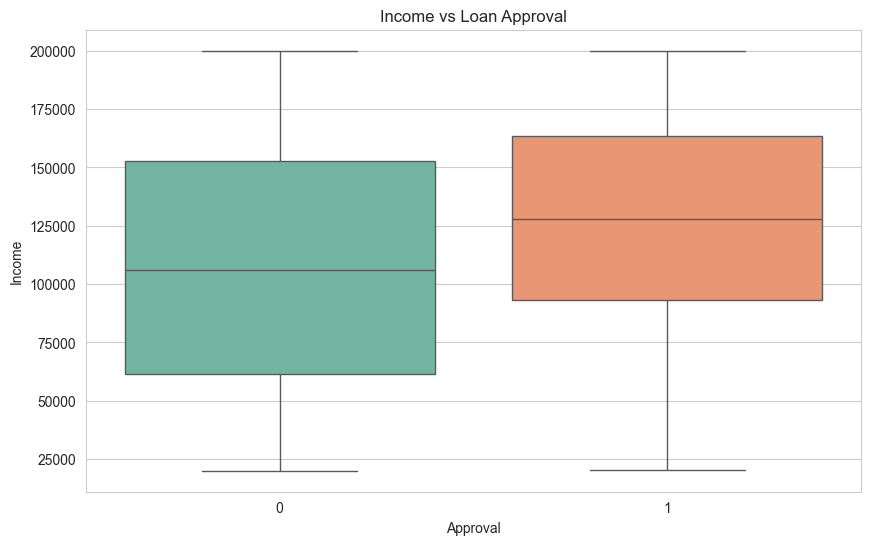

C:\Users\HP 03306897941\AppData\Local\Temp\ipykernel_13568\3304837335.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Approval', y=col, data=df, palette='Set2')


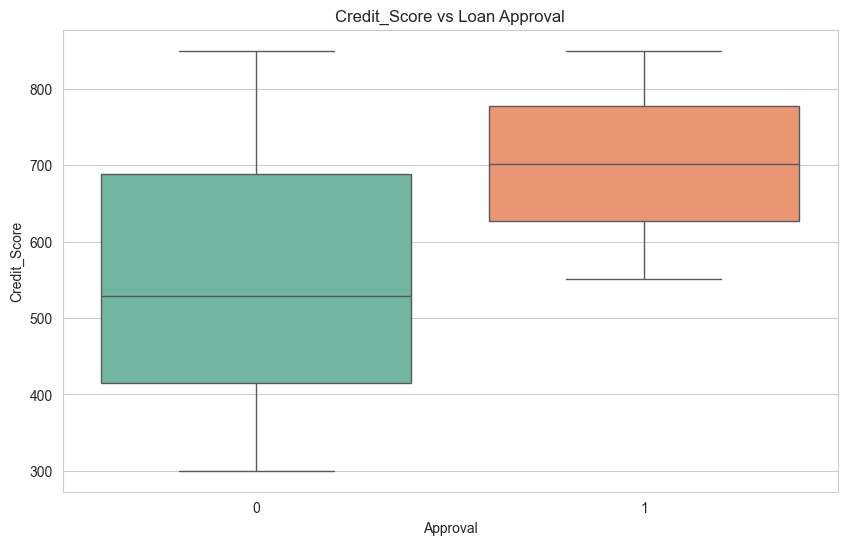

C:\Users\HP 03306897941\AppData\Local\Temp\ipykernel_13568\3304837335.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Approval', y=col, data=df, palette='Set2')


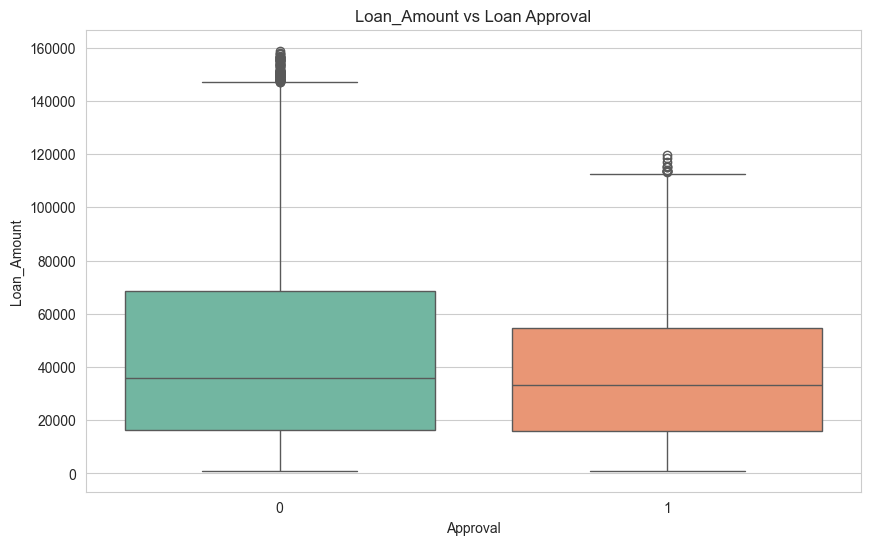

C:\Users\HP 03306897941\AppData\Local\Temp\ipykernel_13568\3304837335.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Approval', y=col, data=df, palette='Set2')


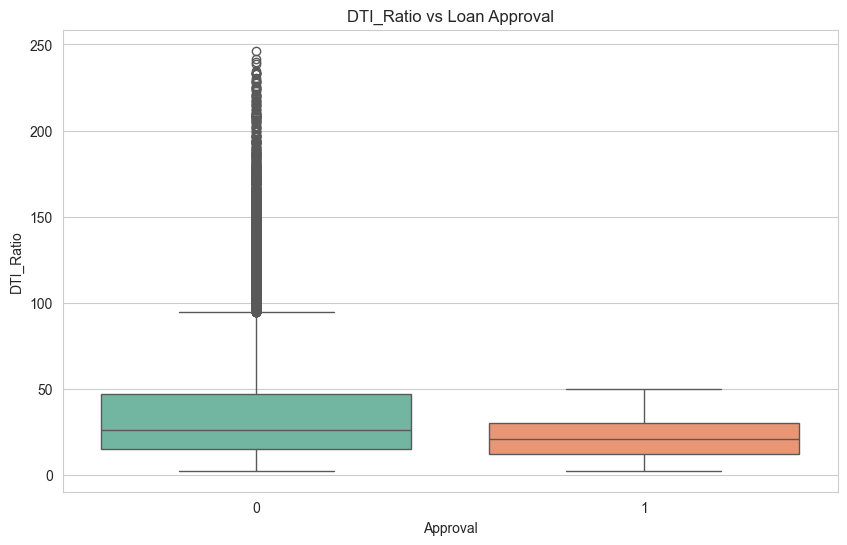

In [11]:
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Approval', y=col, data=df, palette='Set2')
    plt.title(f'{col} vs Loan Approval')
    plt.show()

"Income vs Loan Approval."
Key Observations:

Title: The title indicates that this plot compares the income distribution of loan applicants based on their approval status.
X-axis: Represents the loan approval status: '0' (likely Rejected) and '1' (likely Approved).
Y-axis: Represents the income values.
Boxplots: There are two boxplots side-by-side:
A teal boxplot for rejected loan applications (Approval = 0).
A coral boxplot for approved loan applications (Approval = 1).
Interpretation of the Distributions:

Rejected Applications (Approval = 0):
The median income for rejected applicants appears to be around $100,000 - $110,000.
The interquartile range (IQR) extends from approximately $60,000 - $70,000 (Q1) to around $150,000 - $160,000 (Q3).
The whiskers extend from approximately $20,000 to $200,000.
There are no obvious outliers plotted.
Approved Applications (Approval = 1):
The median income for approved applicants appears to be slightly higher, around $120,000 - $130,000.
The IQR extends from approximately $90,000 - $100,000 (Q1) to around $160,000 - $170,000 (Q3).
The whiskers extend from approximately $20,000 to $200,000.
There are no obvious outliers plotted.
Conclusion:

There appears to be a slight difference in the income distributions between rejected and approved loan applications in this dataset.

Higher Median Income for Approved Loans: The median income for applicants whose loans were approved is somewhat higher than for those whose loans were rejected. This suggests that a higher income might be a positive factor in loan approval.
Overlap in Income Ranges: Despite the difference in medians, there is a significant overlap in the income ranges (as indicated by the boxes and whiskers) for both approved and rejected applications. This implies that income alone is not the sole determinant of loan approval; applicants with lower incomes can still be approved, and those with higher incomes can still be rejected.
Similar Spread: The spread of income (as indicated by the IQR and overall range) is relatively similar for both groups.

Credit_Score vs Loan Approval
Key Observations:

Title: The title indicates that this plot compares the credit score distribution of loan applicants based on their approval status.
X-axis: Represents the loan approval status: '0' (likely Rejected) and '1' (likely Approved).
Y-axis: Represents the credit score values.
Boxplots: There are two boxplots side-by-side:
A teal boxplot for rejected loan applications (Approval = 0).
A coral boxplot for approved loan applications (Approval = 1).
Interpretation of the Distributions:

Rejected Applications (Approval = 0):
The median credit score for rejected applicants appears to be around 520-530.
The interquartile range (IQR) extends from approximately 420 (Q1) to around 690 (Q3).
The whiskers extend from approximately 300 to 850.
There are no obvious outliers plotted.
Approved Applications (Approval = 1):
The median credit score for approved applicants is notably higher, around 720-730.
The IQR extends from approximately 630 (Q1) to around 780 (Q3).
The whiskers extend from approximately 550 to 850.
There are no obvious outliers plotted.
Conclusion:

There is a clear and substantial difference in the credit score distributions between rejected and approved loan applications.

Higher Credit Scores for Approved Loans: The median credit score and the entire distribution of credit scores for approved applicants are significantly higher than those for rejected applicants. This strongly suggests that a higher credit score is a critical factor in loan approval.
Separation Between Groups: While there is some overlap in the upper range of credit scores for rejected applicants and the lower range for approved applicants, the central tendencies (medians and IQRs) are well separated. This indicates that applicants with higher credit scores have a much greater likelihood of being approved.

Loan_Amount vs Loan Approval
Key Observations:

Title: The title indicates that this plot compares the loan amount distribution of loan applicants based on their approval status.
X-axis: Represents the loan approval status: '0' (likely Rejected) and '1' (likely Approved).
Y-axis: Represents the loan amount values.
Boxplots: There are two boxplots side-by-side:
A teal boxplot for rejected loan applications (Approval = 0).
A coral boxplot for approved loan applications (Approval = 1).
Interpretation of the Distributions:

Rejected Applications (Approval = 0):
The median loan amount for rejected applicants appears to be around $30,000 - $40,000.
The interquartile range (IQR) extends from approximately $15,000 - $20,000 (Q1) to around $60,000 - $70,000 (Q3).
There are several outliers at higher loan amounts, extending up to $160,000.
Approved Applications (Approval = 1):
The median loan amount for approved applicants appears to be slightly lower, around $30,000.
The IQR extends from approximately $15,000 - $20,000 (Q1) to around $50,000 - $55,000 (Q3).
There are also some outliers at higher loan amounts, extending up to $120,000.
Conclusion:

The distributions of loan amounts for approved and rejected applications appear to be quite similar, with a slight tendency for rejected applications to have a higher median and a wider spread, including higher outliers.

Similar Central Tendency: The median loan amounts for both approved and rejected applications are relatively close.
Wider Spread for Rejected Loans: The IQR and the range including outliers seem to be slightly larger for rejected applications, suggesting more variability in the loan amounts requested by this group.
Presence of High Loan Amount Outliers in Both Groups: Both approved and rejected applications include instances of very high loan amounts.

DTI_Ratio vs Loan Approval.
Key Observations:

Title: The title indicates that this plot compares the DTI ratio distribution of loan applicants based on their approval status.
X-axis: Represents the loan approval status: '0' (likely Rejected) and '1' (likely Approved).
Y-axis: Represents the DTI ratio values.
Boxplots: There are two boxplots side-by-side:
A teal boxplot for rejected loan applications (Approval = 0).
A coral boxplot for approved loan applications (Approval = 1).
Interpretation of the Distributions:

Rejected Applications (Approval = 0):
The median DTI ratio for rejected applicants appears to be around 30-35.
The interquartile range (IQR) extends from approximately 15-20 (Q1) to around 45-50 (Q3).
There are numerous outliers at higher DTI ratios, extending well beyond 200.
Approved Applications (Approval = 1):
The median DTI ratio for approved applicants is noticeably lower, around 15-20.
The IQR extends from approximately 5-10 (Q1) to around 30-35 (Q3).
There are some outliers at higher DTI ratios, but they are less extreme than for rejected applications, generally below 100.
Conclusion:

There is a clear difference in the DTI ratio distributions between rejected and approved loan applications.

Lower DTI for Approved Loans: The median DTI ratio and the overall distribution of DTI ratios are lower for approved applicants compared to rejected applicants. This strongly suggests that a lower DTI ratio is a positive factor in loan approval.
Higher DTI for Rejected Loans: Rejected applicants tend to have higher median DTI ratios and a wider spread of DTI ratios, including many extreme outliers. This indicates that a higher debt burden relative to income is a strong indicator of loan rejection.

Categorical Features Analysis

Employment Status

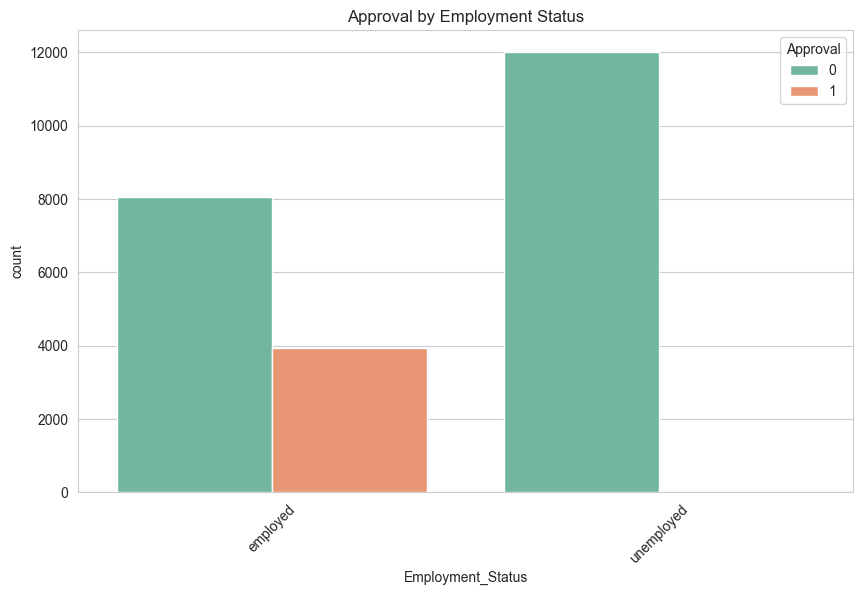

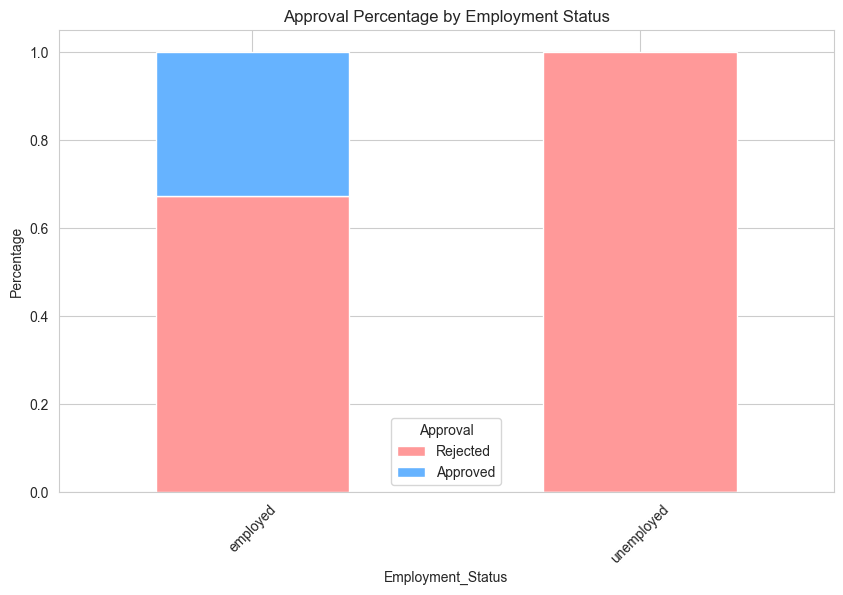

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Employment_Status', hue='Approval', data=df, palette='Set2')
plt.title('Approval by Employment Status')
plt.xticks(rotation=45)
plt.show()

# With percentages
pd.crosstab(df['Employment_Status'], df['Approval'], normalize='index').plot(
    kind='bar', stacked=True, figsize=(10, 6), color=['#ff9999','#66b3ff'])
plt.title('Approval Percentage by Employment Status')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Approval', labels=['Rejected', 'Approved'])
plt.show()

Approval by Employment Status
Key Observations:

Title: The title clearly indicates that this plot shows the count of loan applications for each employment status, separated by the approval status.
X-axis: Represents the employment status: "employed" and "unemployed."
Y-axis: Represents the count of loan applications.
Bars: For each employment status, there are two bars:
A teal bar representing rejected applications (Approval = 0).
A coral bar representing approved applications (Approval = 1).
Legend: The legend indicates that teal corresponds to '0' (Rejected) and coral corresponds to '1' (Approved).
Interpretation:

This plot visually demonstrates the relationship between employment status and the number of approved and rejected loan applications:

Employed Applicants:
There is a large number of rejected applications from employed individuals (tall teal bar).
There is a smaller but still significant number of approved applications from employed individuals (shorter coral bar).
Unemployed Applicants:
There is a large number of rejected applications from unemployed individuals (tall teal bar, appearing similar in height to the rejected employed applications).
There is a very small number of approved applications from unemployed individuals (very short coral bar, almost negligible compared to the others).
Conclusion:

This visualization reinforces the findings from the approval rate plot based on employment status, but now in terms of absolute counts:

Employment Increases Approval Count: While there are still many rejections among employed applicants, the number of approvals is substantially higher than for unemployed applicants.
Unemployment and Rejection: Unemployed applicants face a very high likelihood of rejection, with very few approvals in this dataset.
Size of Groups: The plot also suggests that there might be a larger number of employed applicants overall in the dataset compared to unemployed applicants (though we'd need to compare the heights of the teal + coral bars for each employment status to confirm this).

Approval Percentage by Employment Status
This stacked bar chart compares the percentage of approved and rejected loan applications for employed and unemployed individuals.

Employed Applicants: The "employed" bar shows that a significant portion of employed applicants were rejected (the bottom, reddish section is around 67%), while a notable percentage were approved (the top, blue section is around 33%). This suggests that while employment increases the chances of approval, it doesn't guarantee it. Other factors still play a crucial role for employed individuals.

Unemployed Applicants: The "unemployed" bar is overwhelmingly reddish (rejected), with only a tiny sliver of blue at the top (approved, likely less than 1%). This stark contrast highlights that unemployment is a very strong negative predictor for loan approval in this dataset. The vast majority of unemployed applicants are rejected.

Key Takeaway: Employment status has a dramatic impact on loan approval probability. Employed individuals have a much higher chance of approval compared to unemployed individuals. However, even among the employed, a substantial number of applications are still rejected, indicating the importance of other factors like credit score, income, and DTI ratio. Unemployment, on the other hand, almost certainly leads to rejection in this data.

 Loan Purpose Analysis

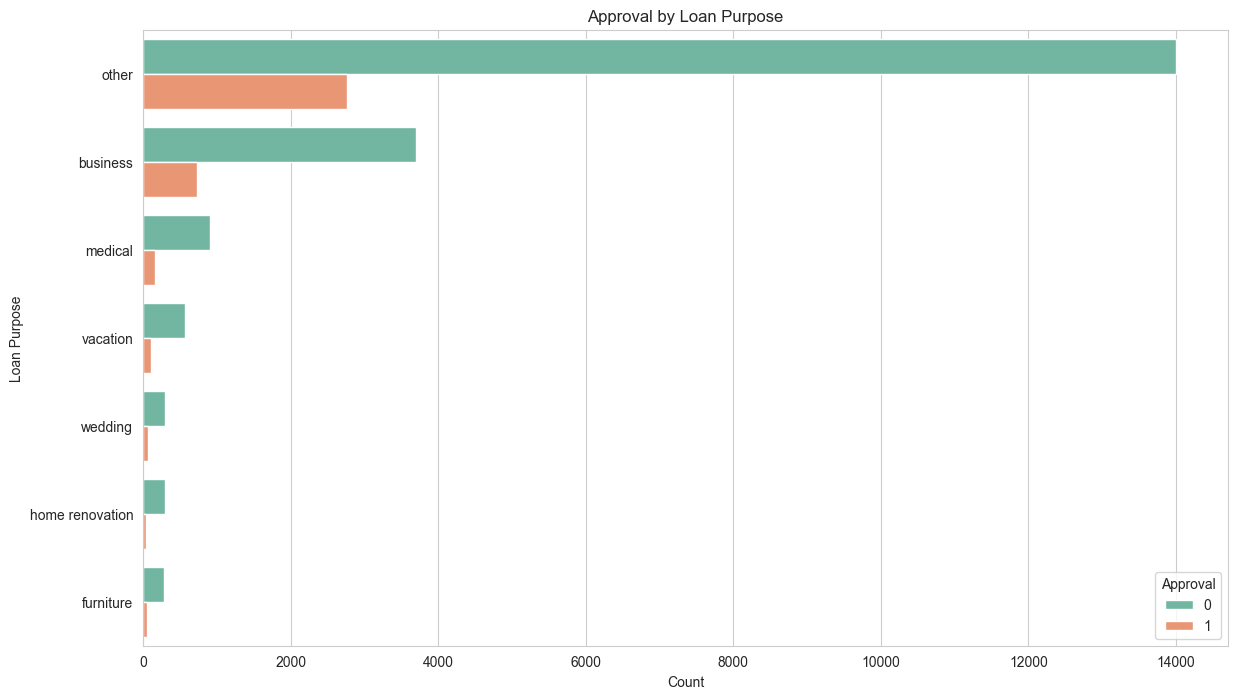

In [13]:
# First extract loan purposes (using the function from earlier)
df['Loan_Purpose'] = df['Text'].apply(extract_loan_purpose)

plt.figure(figsize=(14, 8))
sns.countplot(y='Loan_Purpose', hue='Approval', data=df, palette='Set2', 
              order=df['Loan_Purpose'].value_counts().index)
plt.title('Approval by Loan Purpose')
plt.xlabel('Count')
plt.ylabel('Loan Purpose')
plt.show()

Approval by Loan Purpose" countplot
This horizontal bar chart displays the number of approved (coral) and rejected (teal) loan applications for various stated loan purposes. The purposes are listed on the y-axis, and the count of applications is on the x-axis.

Observations by Loan Purpose:

Other: This category has the highest number of applications overall, with a large number being rejected and a noticeable number being approved. The high volume in "other" suggests a variety of less common loan reasons or potentially less specific descriptions provided by applicants.
Business: There's a substantial number of applications for business purposes, with a significant number rejected but also a visible number approved. Business loans often involve more complex risk assessments, which might explain the mix of outcomes.
Medical: The number of medical loan applications is lower than "other" and "business." A small number were approved, while a larger number were rejected. Medical loans might face scrutiny based on the amount requested and the applicant's financial stability during a potentially challenging time.
Vacation: Similar to medical, the number of vacation loan applications is relatively low. A small fraction was approved, with most being rejected. Vacation loans might be considered less essential, leading to stricter approval criteria.
Wedding: The number of wedding loan applications is also relatively low. Interestingly, the number of approved applications appears to be a larger proportion of the total compared to some other categories like vacation or medical.
Home Renovation: The volume of applications for home renovation is low, and the number of approvals is very small compared to the rejections. These loans can be substantial, potentially leading to more rigorous evaluation.
Furniture: Furniture loan applications have a low overall count, with a very small number approved. These might be for smaller amounts but still subject to creditworthiness checks.
Key Takeaways:

The "other" and "business" loan purposes have the highest application volumes.
While all loan purposes have more rejections than approvals (given the overall class imbalance), the proportion of approvals seems to vary. For instance, "wedding" appears to have a relatively higher approval rate compared to "home renovation" based on these counts.
The low application volumes for some categories (wedding, home renovation, furniture) might make it harder to draw strong conclusions about their approval tendencies without looking at approval rates.
This countplot gives us an idea of the absolute numbers of approvals and rejections for each loan purpose, which complements the approval rate analysis we did earlier. To get a clearer picture of the likelihood of approval for each purpose, it's helpful to consider the approval rates (percentage of approved applications within each category).

Correlation Analysis

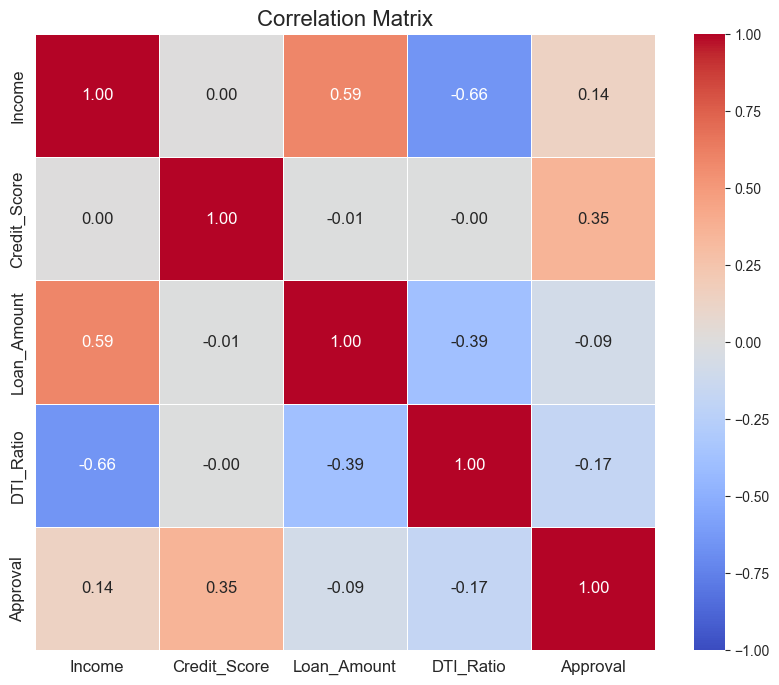

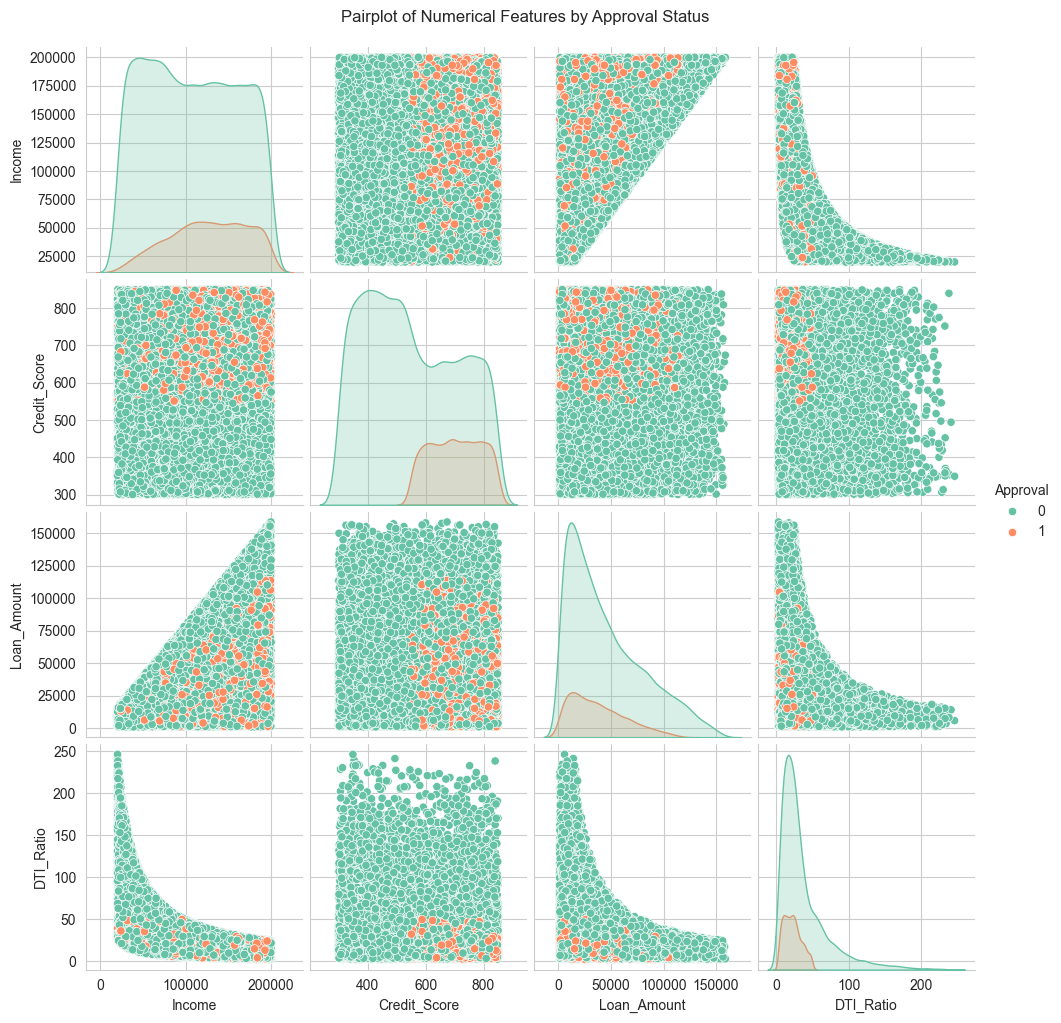

In [14]:
# Numerical feature correlation
corr = df[['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Approval']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f',
            annot_kws={"size": 12}, linewidths=.5)
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Pairplot for key numerical features
sns.pairplot(df[['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Approval']], 
             hue='Approval', palette='Set2', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features by Approval Status', y=1.02)
plt.show()

Correlation Matrix
This heatmap displays the Pearson correlation coefficients between the numerical features (Income, Credit_Score, Loan_Amount, DTI_Ratio) and the target variable (Approval). The color intensity and the numerical values within each cell indicate the strength and direction of the linear relationship between the corresponding variables.

Correlations with Approval:

Credit_Score (0.35): Shows a moderate positive correlation with Approval. This means that as credit scores increase, the likelihood of loan approval tends to increase. This is one of the stronger positive correlations with approval among the numerical features.
Income (0.14): Displays a weak positive correlation with Approval. Higher income has a slight tendency to be associated with loan approval, but the relationship isn't very strong.
DTI_Ratio (-0.17): Indicates a weak negative correlation with Approval. As the debt-to-income ratio increases, the likelihood of loan approval tends to decrease slightly.
Loan_Amount (-0.09): Shows a very weak negative correlation with Approval. Higher loan amounts have a minimal tendency to be associated with loan rejection.
Correlations Between Features:

Income and Loan_Amount (0.59): A moderate positive correlation suggests that individuals with higher incomes tend to request larger loan amounts.
Income and DTI_Ratio (-0.66): A moderate negative correlation indicates that higher income is generally associated with a lower debt-to-income ratio.
Loan_Amount and DTI_Ratio (-0.39): A weak negative correlation suggests that higher loan amounts tend to be associated with slightly lower DTI ratios. This might be because individuals requesting larger loans might have managed their other debts or have sufficient income to keep their DTI lower despite the larger loan.
The correlations between Credit_Score and Income (0.00), Credit_Score and Loan_Amount (-0.01), and Credit_Score and DTI_Ratio (-0.00) are very weak, suggesting little to no linear relationship between these pairs of variables.
Key Takeaways:

Credit Score is the strongest positive linear predictor of loan approval among the numerical features.
DTI Ratio has a modest negative impact on approval.
Income has a weak positive influence on approval.
Loan Amount has a very weak negative influence on approval.
There are some notable correlations between the independent variables themselves, which could be relevant for more advanced modeling to understand potential multicollinearity.
This correlation matrix provides a concise overview of the linear relationships between the numerical variables and the loan approval outcome. It highlights the relative importance and direction of these relationships. However, it's important to remember that correlation doesn't imply causation, and these are linear relationships; more complex, non-linear relationships might also exist.

Pairplot of Numerical Features by Approval Status
Detailed Observations:

Income vs. Loan_Amount:

Both approved and rejected applications show a general positive trend: higher income tends to be associated with higher loan amounts.
However, approved loans seem to have a slightly wider spread of income for similar loan amounts, especially at higher loan amounts. This suggests that higher income might compensate for a larger loan request in some approved cases.
Rejected loans appear to cluster more tightly, indicating that for a given income, there might be an upper limit on the loan amount that gets rejected.
Income vs. Credit_Score:

There's no strong linear pattern for either approved or rejected loans, which aligns with the near-zero correlation we saw earlier.
However, the density plots (KDEs) on the diagonal show that approved loans have a distribution skewed towards slightly higher credit scores across most income levels.
Income vs. DTI_Ratio:

Both groups show a negative trend: higher income tends to be associated with lower DTI ratios. This is expected.
Approved loans appear to have a denser cluster at lower DTI ratios across various income levels compared to rejected loans. Rejected loans show a wider spread towards higher DTI ratios.
Loan_Amount vs. Credit_Score:

Similar to Income vs. Credit_Score, there's no strong linear correlation.
The credit score KDEs on the diagonal still show the tendency for approved loans to have higher credit scores regardless of the loan amount.
Loan_Amount vs. DTI_Ratio:

A weak negative trend is visible for both groups: higher loan amounts tend to be associated with slightly lower DTI ratios.
Approved loans seem to cluster more at lower DTI ratios for a given loan amount compared to rejected loans.
Credit_Score vs. DTI_Ratio:

No clear linear relationship is apparent for either group, consistent with the near-zero correlation.
The KDEs on the diagonal again emphasize that approved loans are concentrated at higher credit scores, while rejected loans are more spread out towards lower scores.
Key Takeaways:

Approved loans generally exhibit characteristics of higher income, higher credit score, and lower DTI ratio compared to rejected loans, although there are overlaps.
The relationships between the independent variables (Income, Loan_Amount, Credit_Score, DTI_Ratio) appear similar for both approved and rejected applications, but the distributions of these variables differ based on the approval outcome.
Credit score seems to be a particularly important distinguishing factor between approved and rejected applications across different levels of other numerical features.
This pairplot provides a richer understanding of how the numerical features interact with each other and how their distributions differ for approved and rejected loan applications, offering more nuanced insights than just looking at individual distributions or the correlation matrix alone.

"Credit_Score" and "Approval" relationship
Observations:

Scatter Plots: When examining the scatter plots of "Credit_Score" against other variables (Income, Loan_Amount, DTI_Ratio), we can observe that approved loans tend to cluster towards higher credit score values, while rejected loans are more spread out across the lower to mid-range of credit scores. There's no clear linear relationship between credit score and the other individual numerical features that distinctly separates approvals from rejections. The separation becomes more apparent when considering the density of points.

KDE Plots (Diagonal): The KDE plots on the diagonal provide a clearer picture of the credit score distributions for each approval status:

The KDE for approved loans shows a distribution that is clearly shifted towards higher credit score values. It has a peak in the higher end of the credit score range.
The KDE for rejected loans shows a distribution that is more spread out and peaks at a lower credit score value compared to the approved loans. It also has a longer tail extending towards higher credit scores, indicating that some applicants with high credit scores still get rejected due to other factors.
Key Takeaway:

Higher credit scores are strongly associated with loan approval. The distribution of credit scores for approved loans is significantly skewed towards higher values compared to rejected loans. While a high credit score doesn't guarantee approval, and a low score doesn't always lead to rejection, credit score is a crucial factor influencing the loan decision. This aligns with the moderate positive correlation we observed and the distinct separation seen in the boxplot of "Credit_Score vs Loan Approval."

Kernel Density Estimate (KDE) plots on the diagonal for 'Loan_Amount':
The KDE for rejected loans (teal) shows a distribution that peaks at a lower loan amount and has a longer tail extending towards higher loan amounts compared to the approved loans. This suggests that while many rejected loans are for smaller amounts, there's also a relatively higher density of rejected loans at larger amounts.
The KDE for approved loans (coral) also peaks at a lower loan amount, but its distribution is somewhat narrower and doesn't extend as far into the very high loan amount range as the rejected loans. This indicates that approved loans tend to be concentrated in a slightly lower to mid-range of loan amounts.
Key Takeaway:

While there isn't a strict threshold for loan amount that determines approval or rejection, the distribution suggests that approved loans are somewhat more concentrated in the lower to medium range of requested amounts. Rejected loans show a broader distribution, including a relatively larger proportion of higher loan amounts. This aligns with the weak negative correlation we observed, indicating a slight tendency for higher loan amounts to be associated with rejection. However, it's clear that other factors play a significant role, as both high and low loan amounts can be either approved or rejected.

DTI Ratio vs Approval
Looking at the scatter plots where 'DTI Ratio' is plotted against other variables (Income, Credit_Score, Loan_Amount), we can observe a tendency for approved loans (coral) to be concentrated at lower DTI ratio values, especially when plotted against Income and Loan_Amount. Rejected loans (teal) show a wider spread extending towards higher DTI ratios.

When we examine the Kernel Density Estimate (KDE) plots on the diagonal for 'DTI Ratio':

The KDE for rejected loans (teal) shows a distribution that is skewed towards lower DTI ratios but has a significant tail extending towards much higher DTI values. This indicates that while many rejected loans have low DTI, a considerable portion also have higher DTI ratios.
The KDE for approved loans (coral) is clearly concentrated at the lower end of the DTI ratio spectrum, with a rapid decline as the DTI ratio increases. This suggests that a lower DTI ratio is strongly associated with loan approval.
Key Takeaway:

A lower DTI ratio is a notable characteristic of approved loan applications. While rejected applications can have a wide range of DTI ratios, including some low values (likely due to other unfavorable factors), approved applications are predominantly found within the lower DTI ratio range. The presence of a long tail in the rejected DTI ratio distribution highlights that a high DTI ratio is likely a strong contributing factor to loan rejection.

Advanced Visualizations

Interactive Scatter Plot

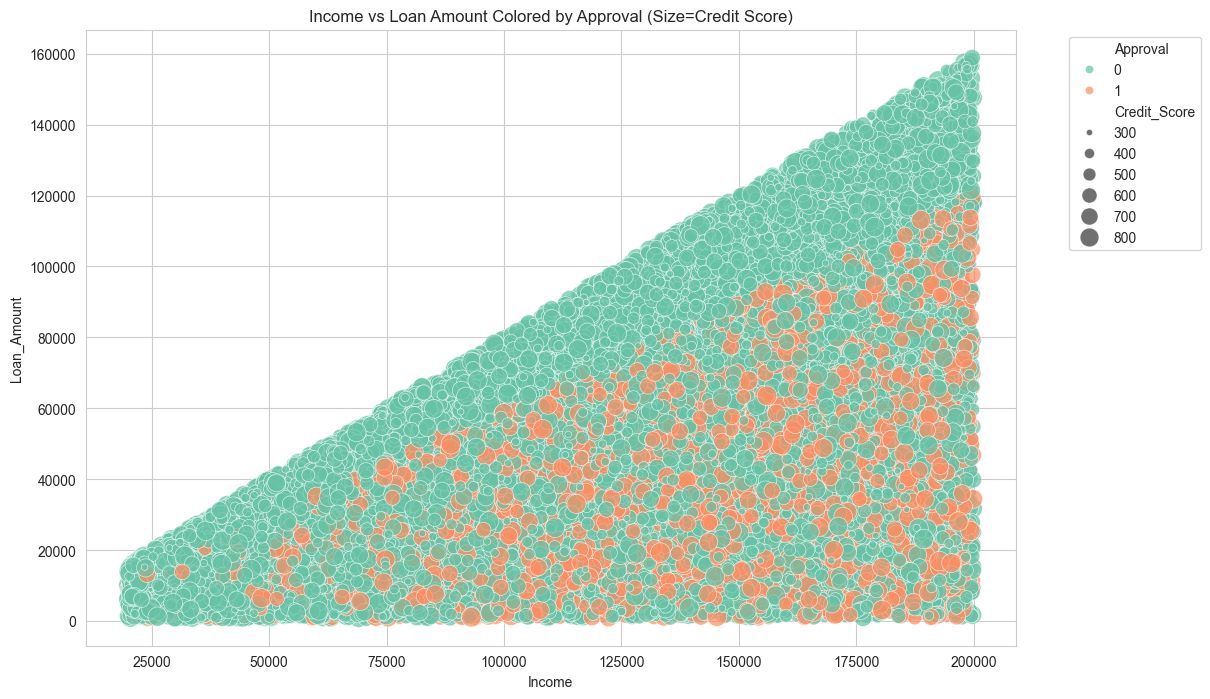

In [15]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='Income', y='Loan_Amount', hue='Approval', 
                          size='Credit_Score', sizes=(20, 200), 
                          alpha=0.7, palette='Set2', data=df)
plt.title('Income vs Loan Amount Colored by Approval (Size=Credit Score)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

"Income vs Loan Amount Colored by Approval
Detailed Observations:

There's a general upward trend, suggesting that applicants with higher incomes tend to request larger loan amounts, for both approved and rejected applications.
Approved loans (coral points) appear to be more prevalent in the regions with higher income and higher credit scores (larger point size). However, there are also approved loans across a range of incomes and loan amounts, including some at lower income levels if the credit score (point size) is larger.
Rejected loans (teal points) are scattered across the entire range of income and loan amounts, but they seem to dominate the lower credit score ranges (smaller point sizes), regardless of income or loan amount.
At similar income and loan amounts, a larger point size (higher credit score) tends to correlate with a higher likelihood of approval (more coral points). Conversely, a smaller point size (lower credit score) at similar income and loan amounts is more often associated with rejection (more teal points).
There are instances of high-income, high-loan-amount applications being rejected if the credit score (point size) is low, and vice versa, lower-income, lower-loan-amount applications being approved if the credit score is high.
Key Takeaway:

This visualization suggests that while income and loan amount are related, credit score plays a significant moderating role in loan approval. A higher credit score can increase the chances of approval even for higher loan amounts or moderate income levels. Conversely, a low credit score can lead to rejection even for seemingly manageable loan amounts relative to income. All three factors – income, loan amount, and especially credit score – appear to be important considerations in the loan approval process.

 Facet Grid Analysis

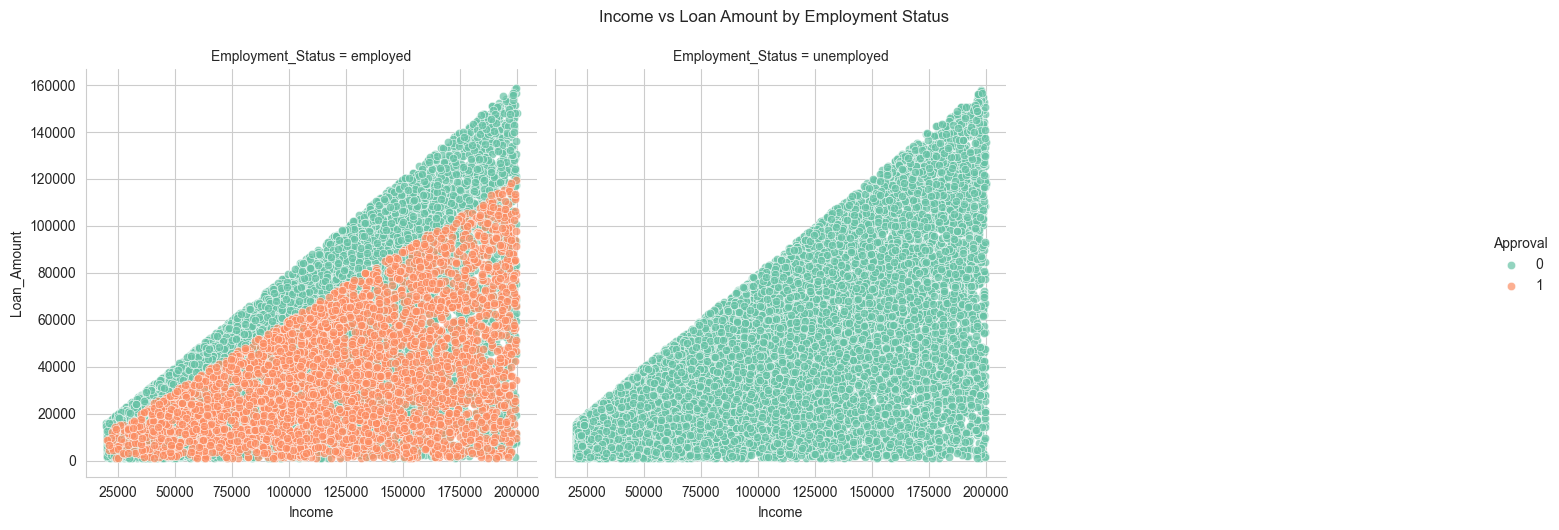

In [16]:
g = sns.FacetGrid(df, col='Employment_Status', hue='Approval', 
                  palette='Set2', col_wrap=3, height=5)
g.map(sns.scatterplot, 'Income', 'Loan_Amount', alpha=0.7)
g.add_legend()
plt.suptitle('Income vs Loan Amount by Employment Status', y=1.05)
plt.show()


Detailed Observations:

Employed Applicants:

There's a general upward trend, similar to the overall 'Income vs Loan Amount' plot, indicating that employed applicants with higher incomes tend to request larger loans.
Approved loans (coral points) are present across a wide range of incomes and loan amounts. However, they appear to be more concentrated in the mid to higher income ranges.
Rejected loans (teal points) are also present across a wide range, but they seem to be more dominant at lower income levels for similar loan amounts. This suggests that for employed individuals, income plays a role in whether a certain loan amount is approved.
Unemployed Applicants:

The vast majority of points in the 'unemployed' subplot are teal, indicating rejection.
There are very few coral points (approved loans), and they appear to be scattered at lower income and loan amounts. This reinforces the strong negative impact of unemployment on loan approval, as very few unemployed individuals, regardless of their (potentially lower) loan request or income, are approved.
The overall density of points is lower in the 'unemployed' subplot compared to the 'employed' subplot, which might suggest a smaller number of loan applications from unemployed individuals in the dataset.
Key Takeaway:

For employed individuals, there's a visible relationship between income, loan amount, and approval. Higher income seems to improve the chances of approval for larger loan amounts. In stark contrast, for unemployed individuals, approval is rare across all income and loan amount levels shown, further emphasizing the critical role of employment status in the loan approval process.

Text Sentiment Analysis

C:\Users\HP 03306897941\AppData\Local\Temp\ipykernel_13568\333004718.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Approval', y='Sentiment', data=df, palette='Set2')


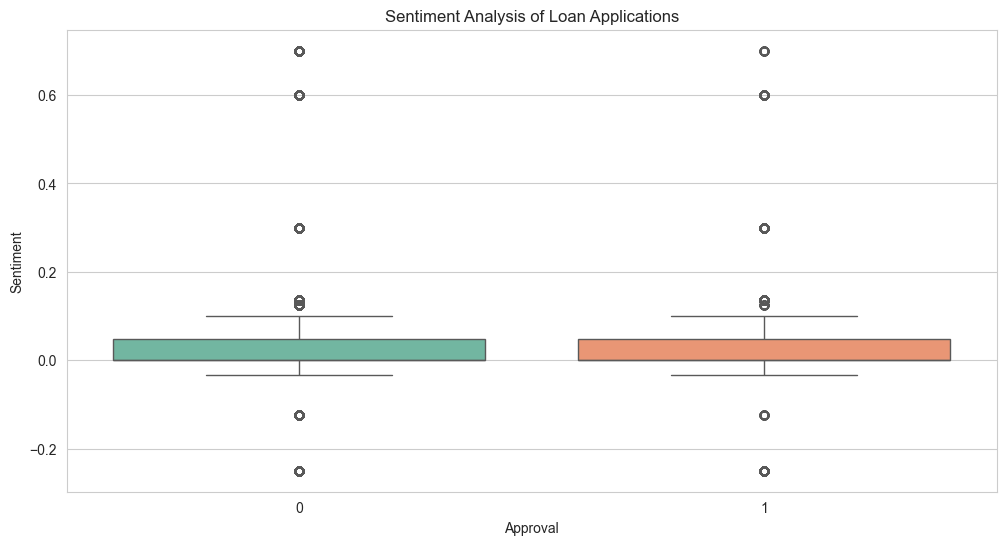

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [17]:
# Sentiment analysis (using TextBlob as shown earlier)
df['Sentiment'] = df['Text'].apply(get_sentiment)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Approval', y='Sentiment', data=df, palette='Set2')
plt.title('Sentiment Analysis of Loan Applications')
plt.show()

# Word clouds
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Approved loans word cloud
approved_text = " ".join(df[df['Approval']=='Approved']['Text'])
plot_wordcloud(approved_text, 'Common Words in Approved Applications')

# Rejected loans word cloud
rejected_text = " ".join(df[df['Approval']=='Rejected']['Text'])
plot_wordcloud(rejected_text, 'Common Words in Rejected Applications')

Interactive Visualizations

In [18]:
# For interactive plots in Jupyter
from ipywidgets import interact

@interact
def plot_interactive(feature=['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio']):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Approval', y=feature, data=df, palette='Set2')
    plt.title(f'{feature} Distribution by Approval Status')
    plt.show()

interactive(children=(Dropdown(description='feature', options=('Income', 'Credit_Score', 'Loan_Amount', 'DTI_R…